### Student Teacher Network Framework
## Quick, moderate performance: preprocessing, model, post processing all done



In [1]:
## Load the data

%load_ext autoreload
%autoreload 2

%pylab inline
import os
import cv2
import time
import numpy as np
import pandas as pd

import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


os.getcwd()
home_dir = os.path.abspath('../../../')
data_dir = os.path.join(home_dir, 'data', 'ua_detrac',  'DETRAC-Images')
data_dir

home_dir

filter_path = os.path.join(home_dir, 'filters')
loader_path = os.path.join(home_dir, 'loaders')

sys.path.append(home_dir)
sys.path.append(loader_path)
sys.path.append(filter_path)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load the data
from loaders.load import Load

start_time = time.time()
load = Load()

eva_dir = home_dir
image_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-data")
anno_dir = os.path.join(eva_dir, "data", "ua_detrac", "small-annotations")

X, length_per_mvi = load.load_images(image_dir, grayscale = False)
Y_dict = load.load_XML(anno_dir, X, length_per_mvi)

print("Total time to load small data is", time.time() - start_time, "seconds")

  0%|          | 5/10421 [00:00<03:45, 46.22it/s]

image directory is  /home/jbang36/eva/data/ua_detrac/small-data
Length of file_names: 10421


100%|██████████| 10421/10421 [01:16<00:00, 135.44it/s]
1it [00:00,  2.24it/s]

MVI_20011.xml
mvi length: 664
car_labels length: 664


2it [00:00,  2.29it/s]

MVI_20012.xml
mvi length: 1600
car_labels length: 1600
MVI_20032.xml
mvi length: 2037
car_labels length: 2037


4it [00:01,  2.85it/s]

MVI_20033.xml
mvi length: 2821
car_labels length: 2821


5it [00:01,  2.84it/s]

MVI_20034.xml
mvi length: 3621
car_labels length: 3621


6it [00:01,  2.72it/s]

MVI_20035.xml
mvi length: 4421
car_labels length: 4421


7it [00:02,  2.69it/s]

MVI_20051.xml
mvi length: 5327
car_labels length: 5327


8it [00:02,  2.76it/s]

MVI_20052.xml
mvi length: 6021
car_labels length: 6021


10it [00:03,  3.28it/s]

MVI_20061.xml
mvi length: 6821
car_labels length: 6821
MVI_20062.xml
mvi length: 7621
car_labels length: 7621


11it [00:03,  3.42it/s]

MVI_20063.xml
mvi length: 8421
car_labels length: 8421


12it [00:04,  2.64it/s]

MVI_20064.xml
mvi length: 9221
car_labels length: 9221


13it [00:04,  2.08it/s]

MVI_20065.xml
mvi length: 10421
car_labels length: 10421
Total time to load small data is 81.76085948944092 seconds


In [3]:

def _split_train_test(X,Y_dict):
    n_samples, _, _, _= X.shape
    print(n_samples)
    train_index_end = int(len(X) * 0.8)
    print(train_index_end)

    X_train = X[:train_index_end]
    X_test = X[train_index_end:]

    Y_dict_train = {}
    Y_dict_test = {}
    for column in Y_dict:
        Y_dict_train[column] = Y_dict[column][:train_index_end]
        Y_dict_test[column] = Y_dict[column][train_index_end:]

    return X_train, X_test, Y_dict_train, Y_dict_test

X_train, X_test, Y_train_dict, Y_test_dict = _split_train_test(X, Y_dict)


10421
8336


In [4]:

X_train_norm = np.copy(X_train)
X_test_norm = np.copy(X_test)

def _format_image_fixed(X, height, width):
    n_samples,_,_,channels = X.shape
    X_new = np.ndarray(shape=(n_samples, height, width, channels))
    for i in range(n_samples):
        X_new[i] = cv2.resize(X[i],  (width,height))
    
    X_new /= 255.0
        
    return X_new


def _format_image(X, sampling_rate=12):
    print("before:", X.shape)
    reduction_rate = sampling_rate
    # need to down shape them so that the kernels can train faster
    # image should be num_samples, height, width, channel
    downsampled_images = X[:, ::reduction_rate, ::reduction_rate, :]
    downsampled_images = downsampled_images.astype(np.float32)
    print("After change, shape of image is", downsampled_images.shape)
    downsampled_images /= 255.0
    return downsampled_images

X_train_norm = _format_image_fixed(X_train_norm, 40, 80)
X_test_norm = _format_image_fixed(X_test_norm, 40, 80)



40 80 3


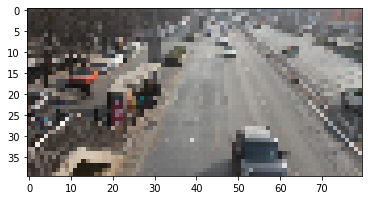

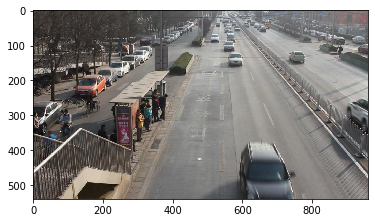

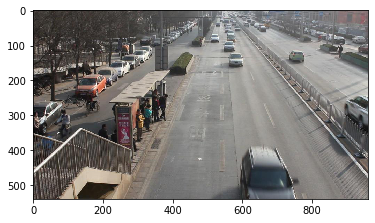

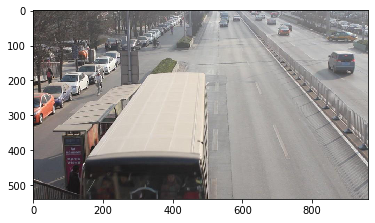

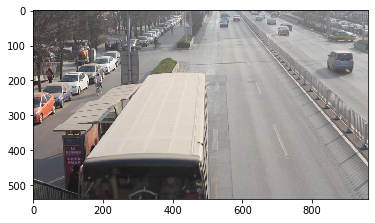

In [5]:

example = X_train_norm[0]
width, height, channels = example.shape
print(width, height, channels)
example = example * 255.0
example = example.astype(np.uint8)



plt.imshow(example)
plt.show()

for i in range(2):
    plt.imshow(X_train[i])
    plt.show()

for i in range(2):
    plt.imshow(X_test[i])
    plt.show()

In [91]:
# remove ipynb_checkpoints

image_dir
mvi_folders = os.listdir(image_dir)
mvi_folders.sort()
height = 40
width = 80
channels = 1

for i, mvi_folder_name in enumerate(mvi_folders):
    file_names = os.listdir(os.path.join(image_dir, mvi_folder_name))
    for file_name in file_names:
        if 'check' in file_name:
            print(mvi_folder_name)
            print("  " + file_name)
    

MVI_20011
  number of files: 664


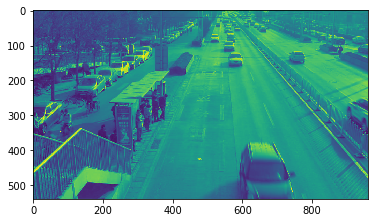

MVI_20012
  number of files: 936


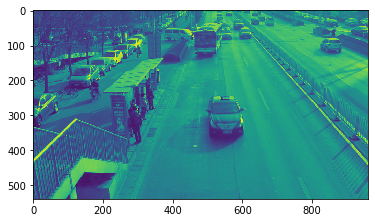

MVI_20032
  number of files: 437


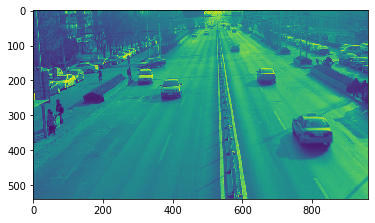

MVI_20033
  number of files: 784


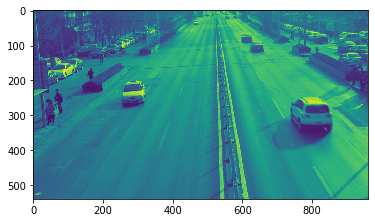

MVI_20034
  number of files: 800


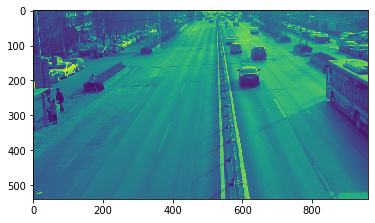

MVI_20035
  number of files: 800


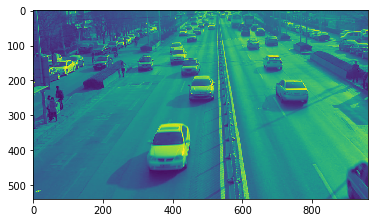

MVI_20051
  number of files: 906


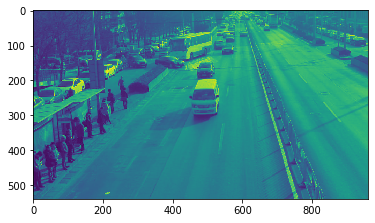

MVI_20052
  number of files: 694


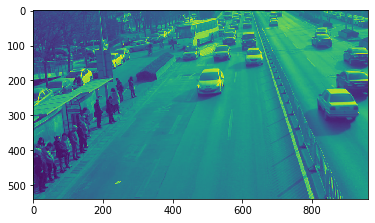

MVI_20061
  number of files: 800


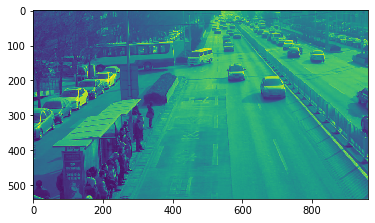

MVI_20062
  number of files: 800


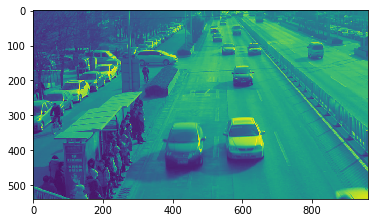

MVI_20063
  number of files: 800


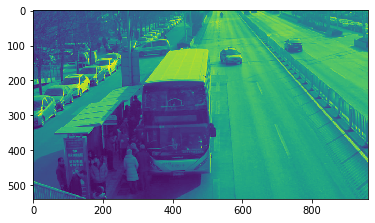

MVI_20064
  number of files: 800


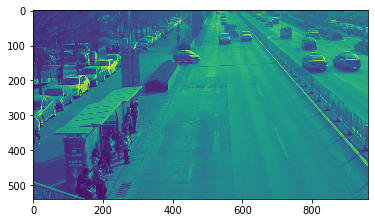

MVI_20065
  number of files: 1200


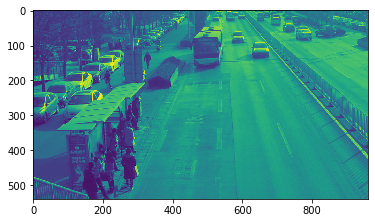

In [10]:
# Examine the images -> if the last two digits are different (ex: MVI_20011, MVI_20056),
#  then the camera angle is different -> hence we should use different instance of background subtraction algorithm

image_dir
mvi_folders = os.listdir(image_dir)
mvi_folders.sort()
height = 40
width = 80
channels = 1
curr_count = 0

for i, mvi_folder_name in enumerate(mvi_folders):
    file_names = os.listdir(os.path.join(image_dir, mvi_folder_name))
    arr = np.ndarray((len(file_names), height, width), dtype = np.uint8)
    print(mvi_folder_name)
    print("  number of files:", len(file_names))
    file_names.sort()
    for j,file_name in enumerate(file_names):
        full_file_name = os.path.join(image_dir, mvi_folder_name, file_name)
        img = cv2.imread(full_file_name, 0)
        
        if j == 0:
            plt.imshow(img)
            plt.show()
    
# Running this shows that if the last two numbers are different, then camera angle (camera) is different

    

In [29]:
def draw_subplot(img, axes, title, gray = True, no_axis = True):
    if gray:
        axes.imshow(img, cmap = 'gray')
    else:
        axes.imshow(img)
    axes.set_title(title)
    if no_axis:
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
    return

In [96]:
# Play with background subtraction algorithms
# Result: KNN background subtraction works best
# Preprocessing Method: (resize, blur, opening, thresholding, resize)
# Save these results


image_dir
mvi_folders = os.listdir(image_dir)
mvi_folders.sort()
height = 40
width = 80
channels = 1
curr_count = 0
train_count = 10421
pre_seg = np.ndarray(shape = (train_count, height, width))
total_count = 0




for i, mvi_folder_name in enumerate(mvi_folders):
    print("folder name:", mvi_folder_name)
    fgbg3 = cv2.createBackgroundSubtractorKNN(detectShadows = True)
    #load the content of that folder
    file_names = os.listdir(os.path.join(image_dir, mvi_folder_name))
    arr = np.ndarray((len(file_names), height, width), dtype = np.uint8)
    masked = np.ndarray((len(file_names), height, width), dtype = np.uint8)
    
    print("  number of files:", len(file_names))
    file_names.sort()
    total_count += len(file_names)
    
    for j,file_name in enumerate(file_names):
        full_file_name = os.path.join(image_dir, mvi_folder_name, file_name)
        img = cv2.imread(full_file_name, 0)
        arr[j] = cv2.resize(img, (width, height))
        fgmask3 = fgbg3.apply(arr[j])
        
    #let the algorithm run for one iteration and then try seeing its results
        
    for k in range(len(file_names)):
        fgmask3 = fgbg3.apply(arr[k])
        pre_seg[curr_count] = fgmask3
        curr_count += 1
        
    print("    done!")
        
    
        
        
        

folder name: MVI_20011
  number of files: 664
    done!
folder name: MVI_20012
  number of files: 936
    done!
folder name: MVI_20032
  number of files: 437
    done!
folder name: MVI_20033
  number of files: 784
    done!
folder name: MVI_20034
  number of files: 800
    done!
folder name: MVI_20035
  number of files: 800
    done!
folder name: MVI_20051
  number of files: 906
    done!
folder name: MVI_20052
  number of files: 694
    done!
folder name: MVI_20061
  number of files: 800
    done!
folder name: MVI_20062
  number of files: 800
    done!
folder name: MVI_20063
  number of files: 800
    done!
folder name: MVI_20064
  number of files: 800
    done!
folder name: MVI_20065
  number of files: 1200
    done!


In [97]:
print(curr_count)
print(total_count)

10421
10421


In [98]:
# preprocessing step
def pre1(seg_output):
    new_seg = np.ndarray(shape = seg_output.shape)
    width_tmp = 200
    height_tmp = 100
    height = seg_output.shape[1]
    width = seg_output.shape[2]
    kernel = np.ones((3,3),np.uint8)
    
    for i in range(seg_output.shape[0]):
        tmp = np.copy(seg_output[i])
        tmp = cv2.resize(tmp, (width_tmp, height_tmp))
        
        #1. Erosion
        #erosion = cv2.erode(tmp, kernel, iterations = 2)
        blur = cv2.GaussianBlur(tmp,(3,3),0)
        opening = cv2.morphologyEx(blur,cv2.MORPH_OPEN, kernel, iterations = 1)
        #2. Dilation
        #sure_bg = cv2.dilate(opening,kernel,iterations=2)
        #3. Threshold
        ret, thresh = cv2.threshold(opening, 0, 255, cv2.THRESH_OTSU)
        new_seg[i] = cv2.resize(thresh, (width, height))
        
    new_seg = new_seg.astype(np.uint8)
    return new_seg




In [101]:
pre_seg = pre_seg.astype(np.uint8)
pre_seg = pre1(pre_seg)

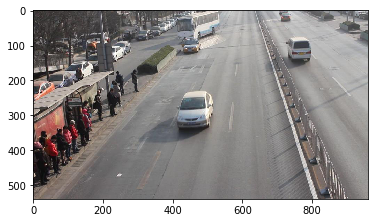

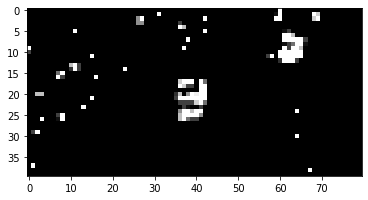

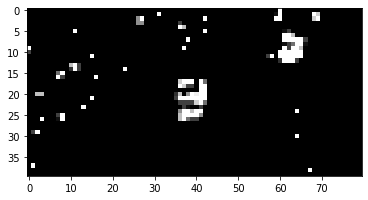

In [109]:
def foo(arr, masked, pre_arr, index):
    plt.imshow(arr[index], cmap = 'gray')
    plt.show()
    plt.imshow(masked[index], cmap = 'gray')
    plt.show()
    plt.imshow(pre_arr[index], cmap = 'gray')
    plt.show()
foo(X_train, pre_seg, pre_seg, 6000)

In [39]:
def draw_random(images, count, gray = True):
    rows = int(count / 4 + 1)
    fig, axes = plt.subplots(rows, 4)
    n_samples = images.shape[0]
    curr_row = 0
    curr_col = 0
    def increment(curr_row, curr_col):
        curr_col += 1
        if curr_col == 4:
            curr_col = 0
            curr_row += 1
        return (curr_row, curr_col)
    
    for i in range(count):
        random_index = random.randint(0, n_samples)
        if gray:
            draw_subplot(images[random_index], axes[curr_row, curr_col], '')
        else:
            draw_subplot(images[random_index], axes[curr_row, curr_col], '', gray = False)
            
        curr_row, curr_col = increment(curr_row, curr_col)
    plt.show()
        


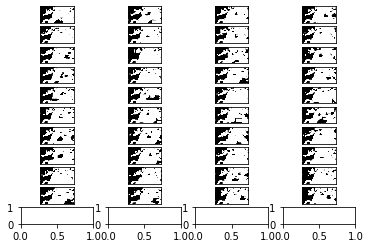

In [40]:
draw_random(pre_arr, 40)

In [97]:
# Write Seg images by MVI folder

image_dir
mvi_folders = os.listdir(image_dir)
mvi_folders.sort()
height = 40a
width = 80
channels = 1
curr_count = 0

for i, mvi_folder_name in enumerate(mvi_folders):
    print("folder name:", mvi_folder_name)
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()
    #load the content of that folder
    file_names = os.listdir(os.path.join(image_dir, mvi_folder_name))
    arr = np.ndarray((len(file_names), height, width), dtype = np.uint8)
    print("  number of files:", len(file_names))
    file_names.sort()
    #fig = plt.figure(figsize=(40,80))
    if os.path.exists('mog_images/'+mvi_folder_name) == False: 
        os.makedirs('mog_images/'+mvi_folder_name)
    
    
    for j,file_name in enumerate(file_names):
        full_file_name = os.path.join(image_dir, mvi_folder_name, file_name)
        img = cv2.imread(full_file_name, 0)
        
        arr[i] = cv2.resize(img, (width, height))
        #print(arr[i].shape)
        fgmask = fgbg.apply(arr[i])
        #fig.add_subplot(1,2,1)
        #plt.imshow(arr[i], cmap = 'gray')
        #fig.add_subplot(1,2,2)
        #plt.imshow(fgmask, cmap = 'gray')
        #plt.show()
        write_name = os.path.join('mog_images', mvi_folder_name, 'image{:06d}.jpg'.format(curr_count))
        cv2.imwrite(write_name, fgmask)
        curr_count += 1
    
    
        
    print("    done!")
        
    
        
        
        

folder name: MVI_20011
  number of files: 664
    done!
folder name: MVI_20012
  number of files: 936
    done!
folder name: MVI_20032
  number of files: 437
    done!
folder name: MVI_20033
  number of files: 784
    done!
folder name: MVI_20034
  number of files: 800
    done!
folder name: MVI_20035
  number of files: 800
    done!
folder name: MVI_20051
  number of files: 906
    done!
folder name: MVI_20052
  number of files: 694
    done!
folder name: MVI_20061
  number of files: 800
    done!
folder name: MVI_20062
  number of files: 800
    done!
folder name: MVI_20063
  number of files: 800
    done!
folder name: MVI_20064
  number of files: 800
    done!
folder name: MVI_20065
  number of files: 1200
    done!


In [122]:
# Writing our model
class Autoencoder_seg(nn.Module):
    def __init__(self):
        super(Autoencoder_seg,self).__init__()
        
        self.K = 10
        self.output_channels = 1
        self.input_channels = 3
        self.seg_channels = 2
        self.middle_neural_count = 100
        
        self.create_enc()
        input_shape = (64, 10, 20) #input (3,40,80)
        self.create_central(input_shape)
        self.create_decoder_b()
        
    def forward(self,x):
        x1 = self.u_enc1(x)
        x2 = self.u_enc2(x1)
        x3 = self.u_enc3(x2)
        #print(x1.shape)
        n,c,h,w = x3.shape
        compressed = self.central_layers1(x3.view(n, c*h*w))
        extended = self.central_layers2(compressed)
        
        xb1 = self.u_decb1(torch.cat( (x3, extended.view(n, c, h, w)), dim = 1))
        xb2 = self.u_decb2(torch.cat( (x2, xb1), dim = 1))
        final_regen = self.u_decb3(torch.cat( (x1, xb2), dim = 1))
        
        
        #return [compressed, background_regen, foreground_regen, final_regen]
        return [compressed, final_regen]
    
    def create_enc(self):
        self.u_enc1 = nn.Sequential()
        self.u_enc1.add_module('Conv1_1', nn.Conv2d(self.input_channels, 16, kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Relu1_2', nn.ReLU(True))
        self.u_enc1.add_module('Conv1_3', nn.Conv2d(16,16,kernel_size=3, padding = (1,1)))
        self.u_enc1.add_module('Drop1_35', nn.Dropout2d(p = 0.1))
        self.u_enc1.add_module('Relu1_4', nn.ReLU(True))
        
        self.u_enc2 = nn.Sequential()
        self.u_enc2.add_module('Max2_0', nn.MaxPool2d(2, stride = 2))
        self.u_enc2.add_module('Conv2_1', nn.Conv2d(16, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Relu2_2', nn.ReLU(True))
        self.u_enc2.add_module('Conv2_3', nn.Conv2d(32, 32, kernel_size=3, padding = (1,1)))
        self.u_enc2.add_module('Drop2_35', nn.Dropout2d(p = 0.1))
        self.u_enc2.add_module('Relu2_4', nn.ReLU(True))
        
        
        self.u_enc3 = nn.Sequential()
        self.u_enc3.add_module('Max3_0', nn.MaxPool2d(2, stride = 2))
        self.u_enc3.add_module('Conv3_1', nn.Conv2d(32, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Relu3_2', nn.ReLU(True))
        self.u_enc3.add_module('Conv3_3', nn.Conv2d(64, 64, kernel_size=3, padding = (1,1)))
        self.u_enc3.add_module('Drop3_35', nn.Dropout2d(p = 0.1))
        self.u_enc3.add_module('Relu3_4', nn.ReLU(True))
        
        
    def create_central(self, input_shape):
        c,h,w = input_shape
        self.central_layers1 = nn.Sequential()
        self.central_layers1.add_module('Mlp', nn.Linear(c*h*w, self.middle_neural_count))
        
        self.central_layers2 = nn.Sequential()
        self.central_layers2.add_module('Mlp', nn.Linear(self.middle_neural_count, c*h*w))
        
    def create_decoder_b(self):
        self.u_decb1 = nn.Sequential()
        #self.u_decb1.add_module('CT4_1', nn.ConvTranspose2d(64, 64, kernel_size = 2, stride = 2))
        self.u_decb1.add_module('Conv4_2', nn.Conv2d(128, 64, kernel_size=3, padding = (1,1)))
        self.u_decb1.add_module('Relu4_3', nn.ReLU(True))
        self.u_decb1.add_module('Conv4_4', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decb1.add_module('Drop4_35', nn.Dropout2d(p = 0.1))
        self.u_decb1.add_module('Relu4_5', nn.ReLU(True))
        self.u_decb1.add_module('CT4_6', nn.ConvTranspose2d(32, 32, kernel_size = 2, stride = 2))
        
        
        self.u_decb2 = nn.Sequential()
        self.u_decb2.add_module('Conv5_2', nn.Conv2d(64, 32, kernel_size=3, padding = (1,1)))
        self.u_decb2.add_module('Relu5_3', nn.ReLU(True))
        self.u_decb2.add_module('Conv5_4', nn.Conv2d(32, 16, kernel_size=3, padding = (1,1)))
        self.u_decb2.add_module('Drop5_35', nn.Dropout2d(p = 0.1))
        self.u_decb2.add_module('Relu5_5', nn.ReLU(True))
        self.u_decb2.add_module('CT5_6', nn.ConvTranspose2d(16, 16, kernel_size = 2, stride = 2))
        
        
        self.u_decb3 = nn.Sequential()
        self.u_decb3.add_module('Conv6_2', nn.Conv2d(32, 8, kernel_size=3, padding = (1,1)))
        self.u_decb3.add_module('Relu6_3', nn.ReLU(True))
        self.u_decb3.add_module('Conv6_4', nn.Conv2d(8, self.output_channels, kernel_size=3, padding = (1,1)))
        self.u_decb3.add_module('Relu6_5', nn.ReLU(True))
        
    

In [123]:
def custom_distance_loss(y_hat, target, loss_amp_factor):
    return loss_amp_factor * ((y_hat - target)**2).mean()

In [9]:
# TODO: Need to load the segmented image... and use this as comparison....
# Fix this box below...

seg_dir = os.path.join(os.getcwd(), 'mog_images')
mvi_folders = os.listdir(seg_dir)
mvi_folders.sort()

height = 40
width = 80
channels = 1
curr_count = 0

seg_X = np.ndarray((X.shape[0],height, width))

for i, mvi_folder_name in enumerate(mvi_folders):
    if '.ipynb_checkpoints' in mvi_folder_name:
        continue
    print("folder name:", mvi_folder_name)
    #load the content of that folder
    file_names = os.listdir(os.path.join(seg_dir, mvi_folder_name))
    print("  number of files:", len(file_names))
    file_names.sort()
    
    for j,file_name in enumerate(file_names):
        full_file_name = os.path.join(seg_dir, mvi_folder_name, file_name)
        seg_X[curr_count] = cv2.imread(full_file_name, 0)    
        curr_count += 1
    

print(curr_count)
print(X.shape)
print(seg_X.shape)
assert(curr_count == seg_X.shape[0])

seg_test = seg_X[int(len(seg_X) * 0.8):]
seg_train = seg_X[:int(len(seg_X) * 0.8)]
    

folder name: MVI_20011
  number of files: 664
folder name: MVI_20012
  number of files: 936
folder name: MVI_20032
  number of files: 437
folder name: MVI_20033
  number of files: 784
folder name: MVI_20034
  number of files: 800
folder name: MVI_20035
  number of files: 800
folder name: MVI_20051
  number of files: 906
folder name: MVI_20052
  number of files: 694
folder name: MVI_20061
  number of files: 800
folder name: MVI_20062
  number of files: 800
folder name: MVI_20063
  number of files: 800
folder name: MVI_20064
  number of files: 800
folder name: MVI_20065
  number of files: 1200
10421
(10421, 540, 960, 3)
(10421, 40, 80)


In [112]:

seg_test = pre_seg[int(len(pre_seg) * 0.8):]
seg_train = pre_seg[:int(len(pre_seg) * 0.8)]

In [113]:
# before creating the dataloader, we need to augment the data
# Debugging: np.set_printoptions(threshold=sys.maxsize)
#            seg_train[1]

seg_train_norm = seg_train / 255.0
seg_test_norm = seg_test / 255.0


In [124]:
import gc
gc.collect()


torch.cuda.empty_cache() 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.cuda.device(0)

In [130]:
model = Autoencoder_seg().cuda()
distance = nn.MSELoss()

# Loss Function Revision

batch_size = 64
n_samples, H, W, C = X_train_norm.shape



train_data = torch.from_numpy(X_train_norm).float()
train_data = train_data.permute(0,3,1,2)



seg_data = torch.from_numpy(seg_train_norm).float() 
seg_data = seg_data.unsqueeze_(-1)
print(seg_data.size())
seg_data = seg_data.permute(0,3,1,2)
print(seg_data.size())

train_loader = torch.utils.data.DataLoader(torch.cat((train_data,seg_data), dim = 1), shuffle=False, batch_size=batch_size, num_workers=4, drop_last=True)

#dist_diff_matrix = calculate_dist_matrix(batch_size, H,W)

torch.Size([8336, 40, 80, 1])
torch.Size([8336, 1, 40, 80])


In [131]:
def convert(recon):
    recon_p = recon.permute(0,2,3,1)
    #print(recon_p.size())
    recon_imgs = recon_p.detach().cpu().numpy()
    recon_imgs *= 255
    recon_imgs = recon_imgs.astype(np.uint8)
    return recon_imgs

def convert_one(recon):
    recon_p = recon.permute(0,2,3,1)
    #print(recon_p.size())
    recon_imgs = recon_p.detach().cpu().numpy()
    recon_imgs *= 255
    recon_imgs = recon_imgs.astype(np.uint8)
    recon_imgs = recon_imgs.squeeze()
    return recon_imgs

def convert_soft(seged):
    K = 2


    N,K,H,W = seged.size()
    arged = torch.argmax(seged, dim = 1) #channels is 1
    arged = arged * 255 / (K - 1)
    arged_imgs = arged.detach().cpu().numpy()


    arged_imgs = arged_imgs.astype(np.uint8)
    assert(arged_imgs.shape == (N,H,W))
    return arged_imgs

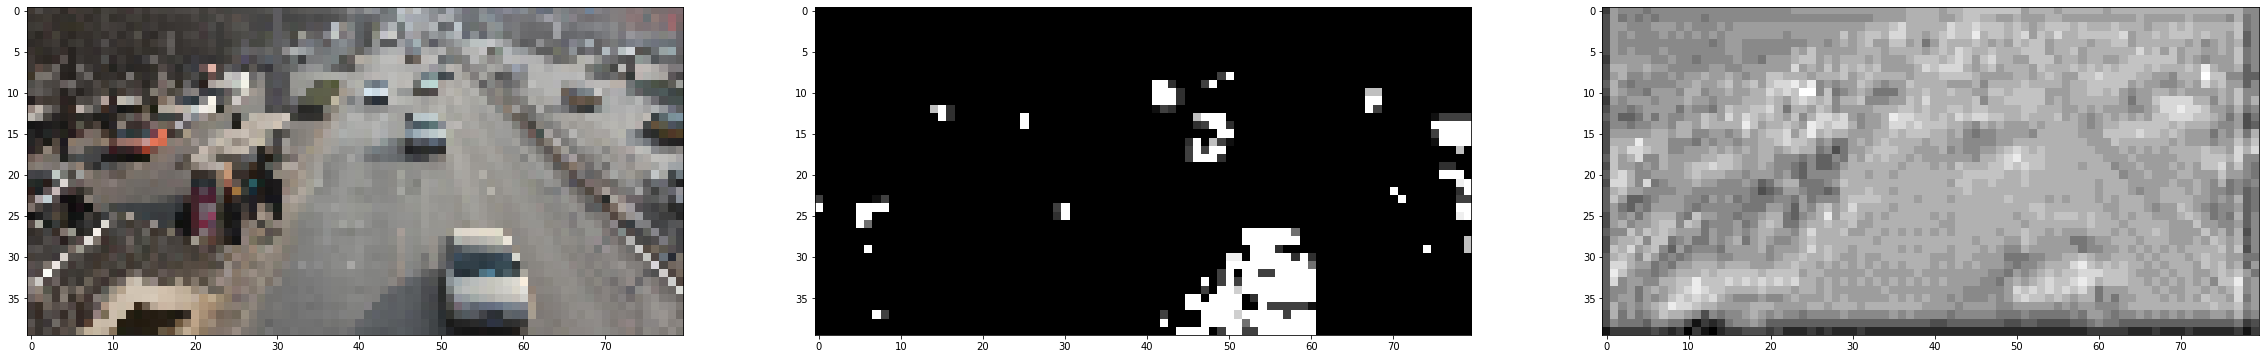

epoch [1/100], loss_total:0.0405, time elapsed:6.7587 (sec)
epoch [2/100], loss_total:0.0401, time elapsed:4.3661 (sec)
epoch [3/100], loss_total:0.0399, time elapsed:4.4365 (sec)
epoch [4/100], loss_total:0.0404, time elapsed:4.4082 (sec)
epoch [5/100], loss_total:0.0388, time elapsed:4.6650 (sec)


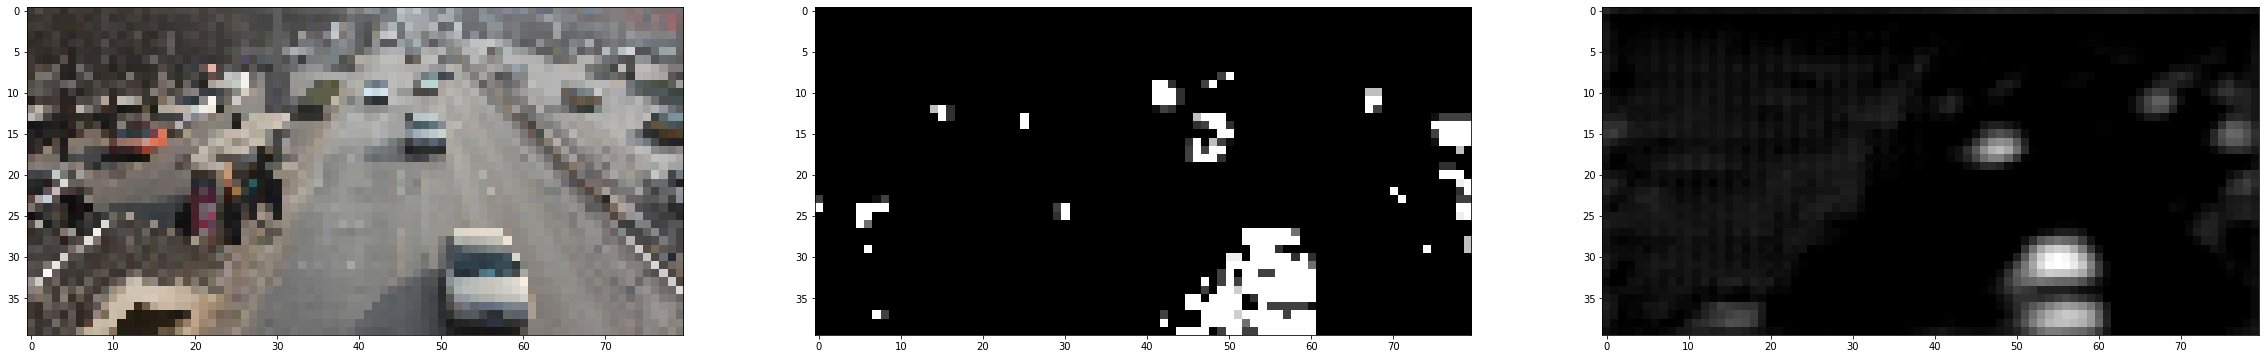

epoch [6/100], loss_total:0.0384, time elapsed:6.5770 (sec)
epoch [7/100], loss_total:0.0379, time elapsed:4.4494 (sec)
epoch [8/100], loss_total:0.0375, time elapsed:4.3468 (sec)
epoch [9/100], loss_total:0.0369, time elapsed:4.3344 (sec)
epoch [10/100], loss_total:0.0367, time elapsed:4.1051 (sec)


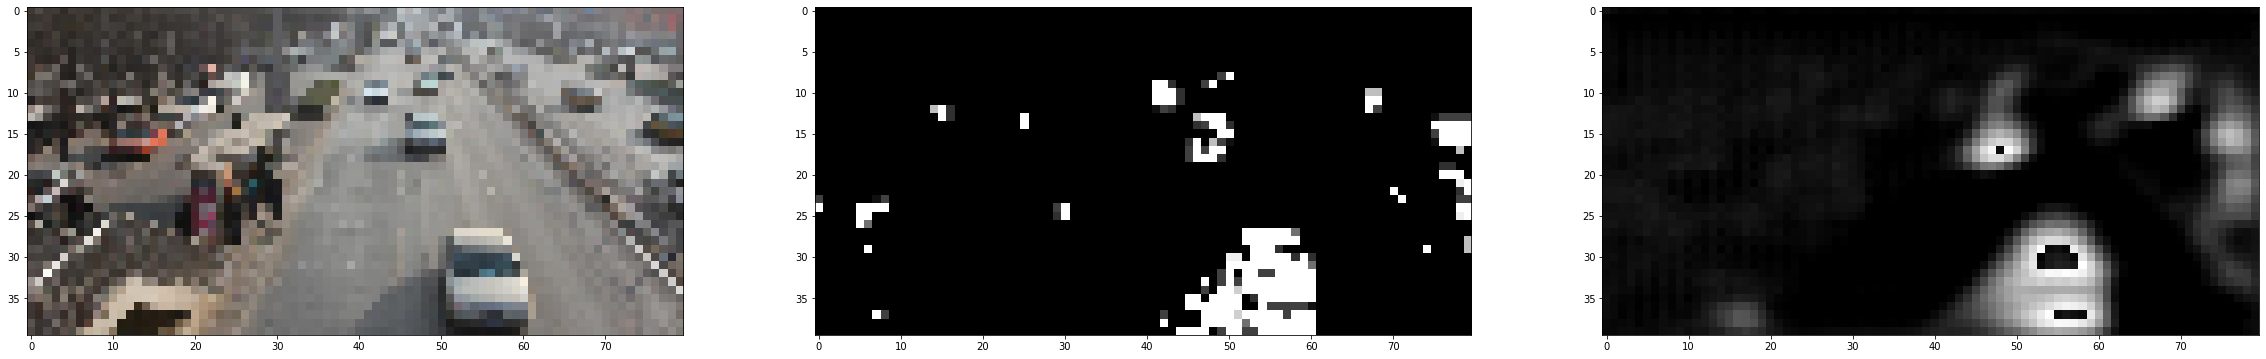

epoch [11/100], loss_total:0.0364, time elapsed:6.4530 (sec)
epoch [12/100], loss_total:0.0367, time elapsed:4.1723 (sec)
epoch [13/100], loss_total:0.0364, time elapsed:4.0288 (sec)
epoch [14/100], loss_total:0.0368, time elapsed:4.1841 (sec)
epoch [15/100], loss_total:0.0366, time elapsed:4.2267 (sec)


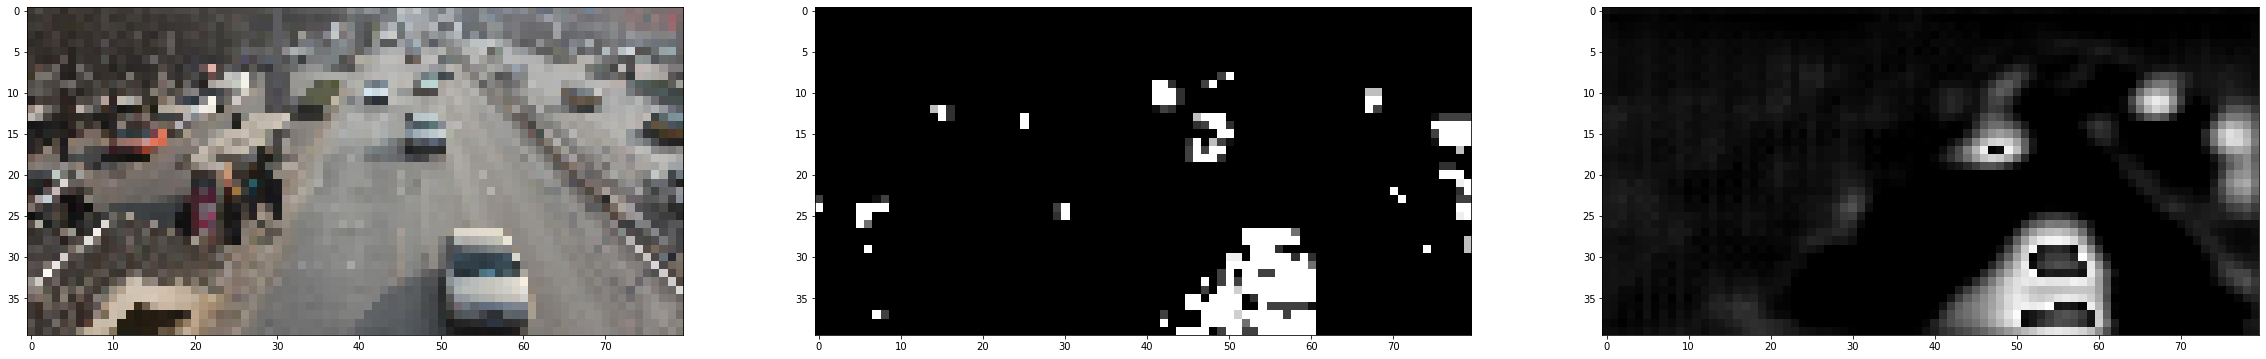

epoch [16/100], loss_total:0.0364, time elapsed:6.4664 (sec)
epoch [17/100], loss_total:0.0362, time elapsed:4.1894 (sec)
epoch [18/100], loss_total:0.0359, time elapsed:4.0932 (sec)
epoch [19/100], loss_total:0.0361, time elapsed:4.1220 (sec)
epoch [20/100], loss_total:0.0363, time elapsed:4.2849 (sec)


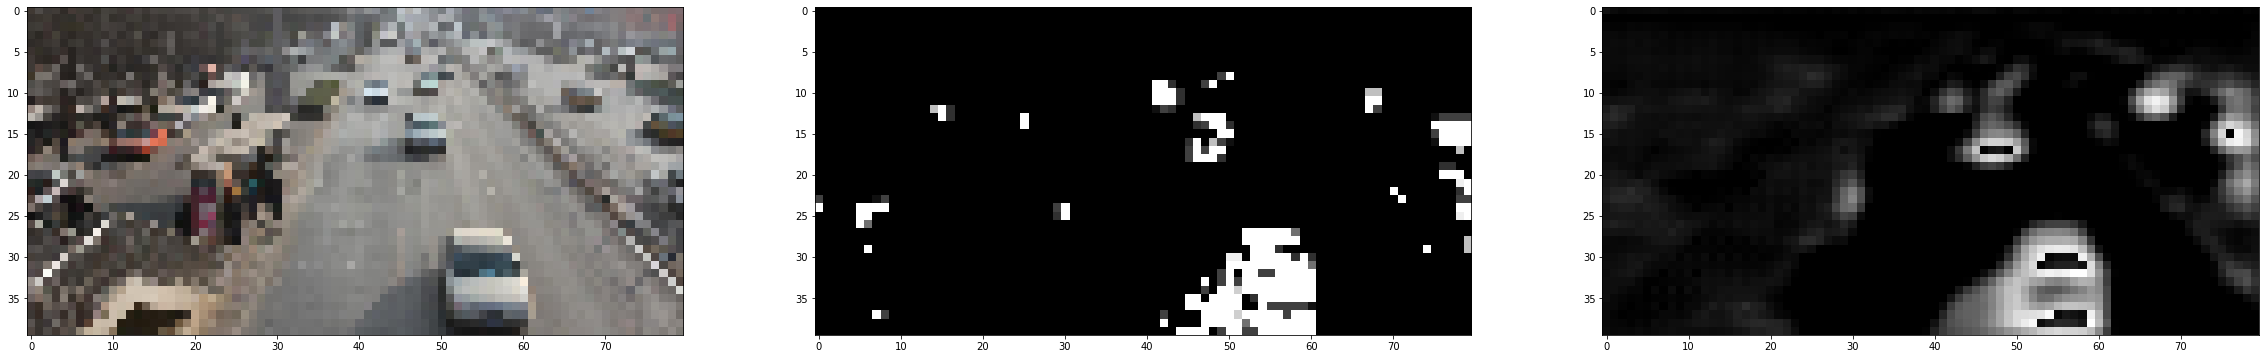

epoch [21/100], loss_total:0.0362, time elapsed:6.6758 (sec)
epoch [22/100], loss_total:0.0367, time elapsed:4.2092 (sec)
epoch [23/100], loss_total:0.0360, time elapsed:4.1097 (sec)
epoch [24/100], loss_total:0.0366, time elapsed:4.1477 (sec)
epoch [25/100], loss_total:0.0357, time elapsed:4.2839 (sec)


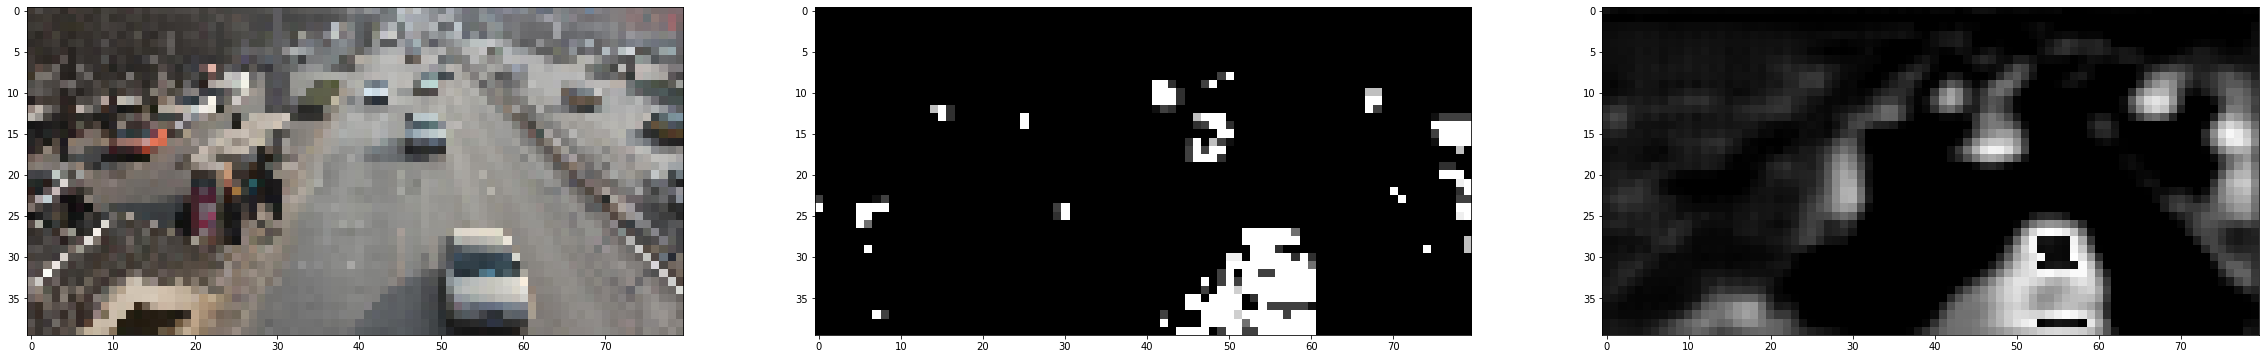

epoch [26/100], loss_total:0.0359, time elapsed:6.7343 (sec)
epoch [27/100], loss_total:0.0347, time elapsed:4.0272 (sec)
epoch [28/100], loss_total:0.0344, time elapsed:4.2589 (sec)
epoch [29/100], loss_total:0.0338, time elapsed:4.1800 (sec)
epoch [30/100], loss_total:0.0333, time elapsed:4.1939 (sec)


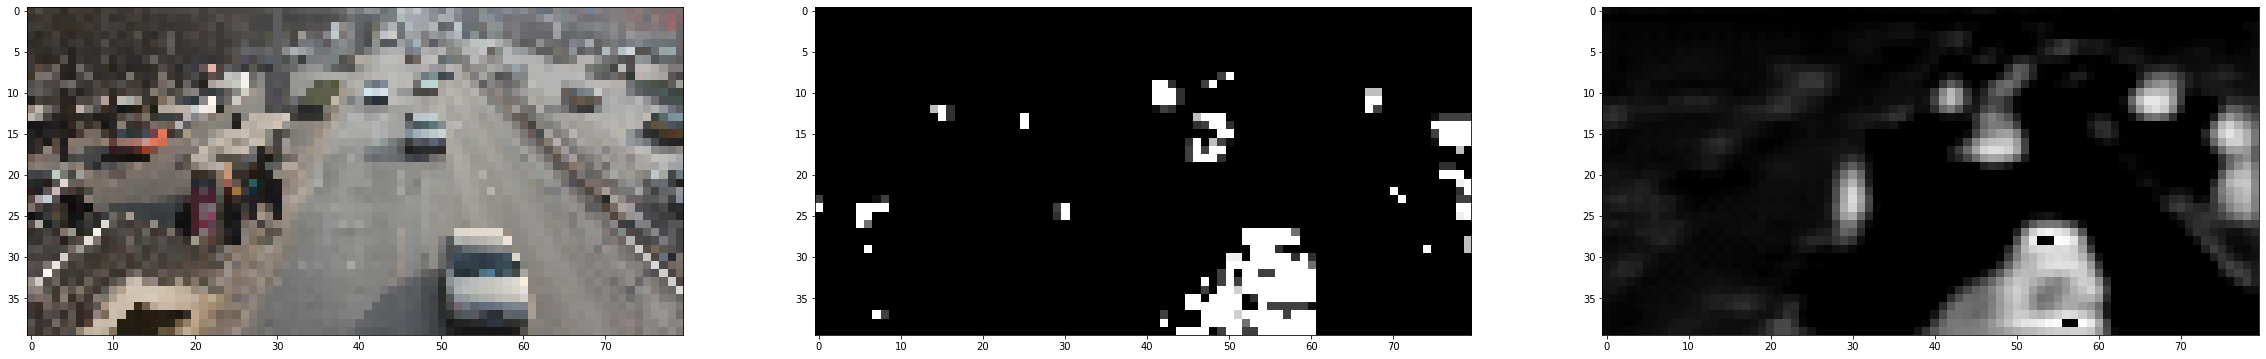

epoch [31/100], loss_total:0.0334, time elapsed:6.6972 (sec)
epoch [32/100], loss_total:0.0327, time elapsed:4.1473 (sec)
epoch [33/100], loss_total:0.0321, time elapsed:4.2456 (sec)
epoch [34/100], loss_total:0.0328, time elapsed:4.2369 (sec)
epoch [35/100], loss_total:0.0331, time elapsed:4.1517 (sec)


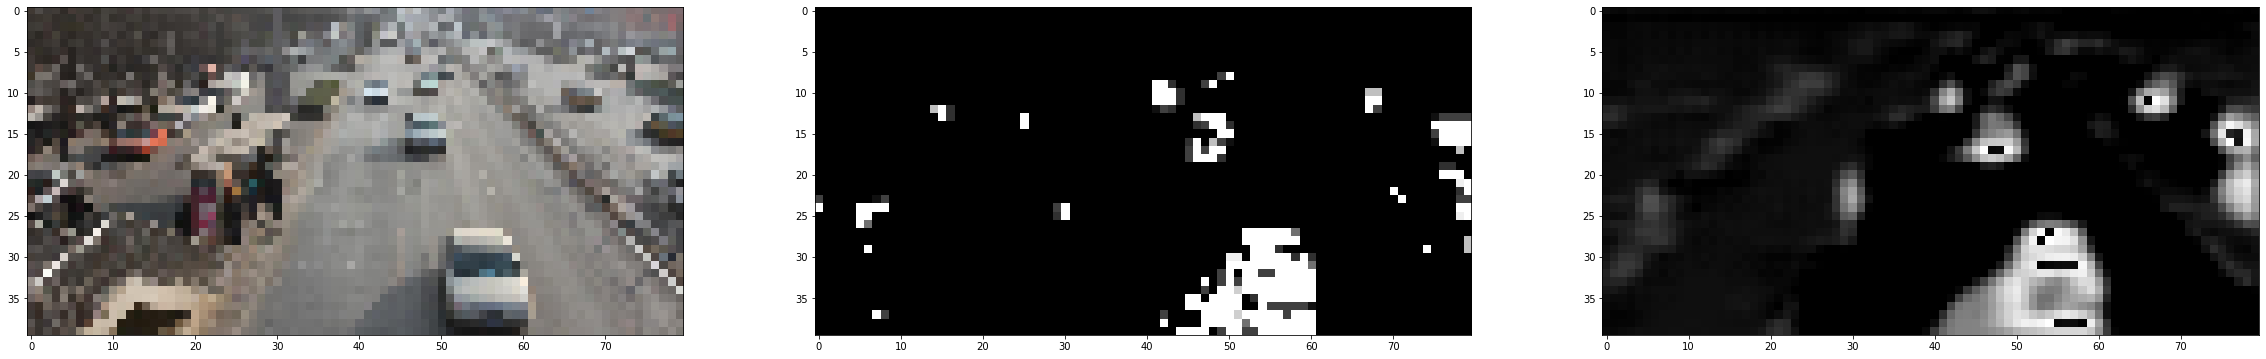

epoch [36/100], loss_total:0.0318, time elapsed:6.3980 (sec)
epoch [37/100], loss_total:0.0315, time elapsed:4.3608 (sec)
epoch [38/100], loss_total:0.0303, time elapsed:4.2768 (sec)
epoch [39/100], loss_total:0.0312, time elapsed:4.0725 (sec)
epoch [40/100], loss_total:0.0295, time elapsed:4.3240 (sec)


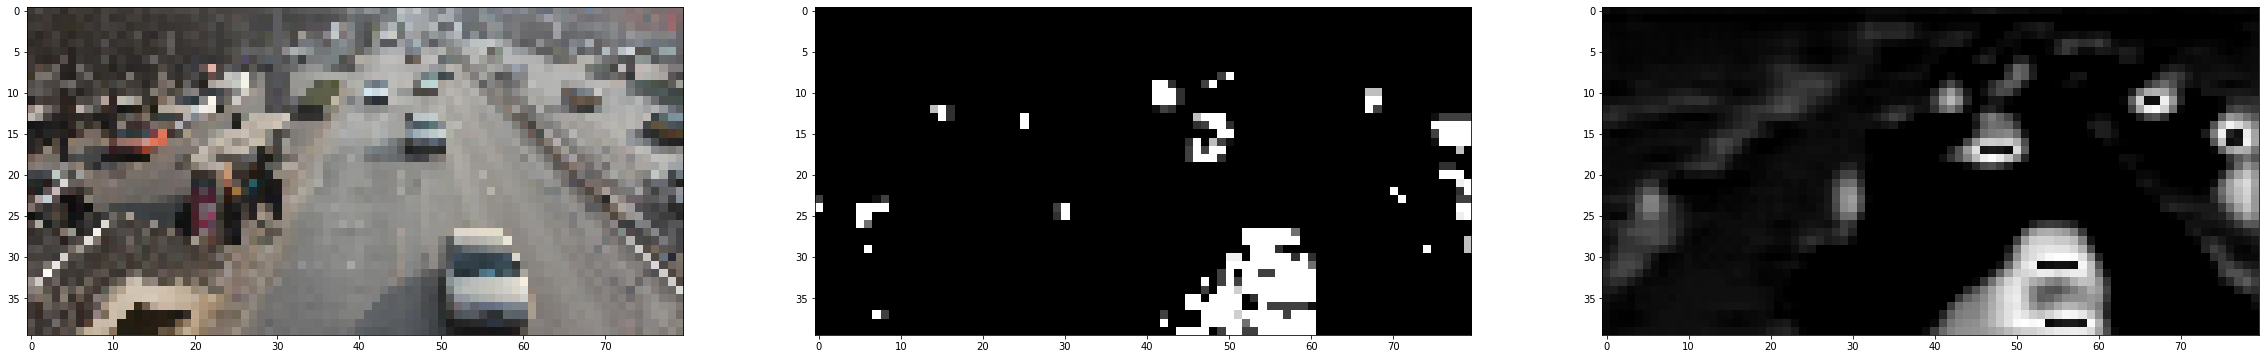

epoch [41/100], loss_total:0.0297, time elapsed:7.1385 (sec)
epoch [42/100], loss_total:0.0284, time elapsed:4.3660 (sec)
epoch [43/100], loss_total:0.0282, time elapsed:4.2995 (sec)
epoch [44/100], loss_total:0.0274, time elapsed:4.3564 (sec)
epoch [45/100], loss_total:0.0275, time elapsed:4.2930 (sec)


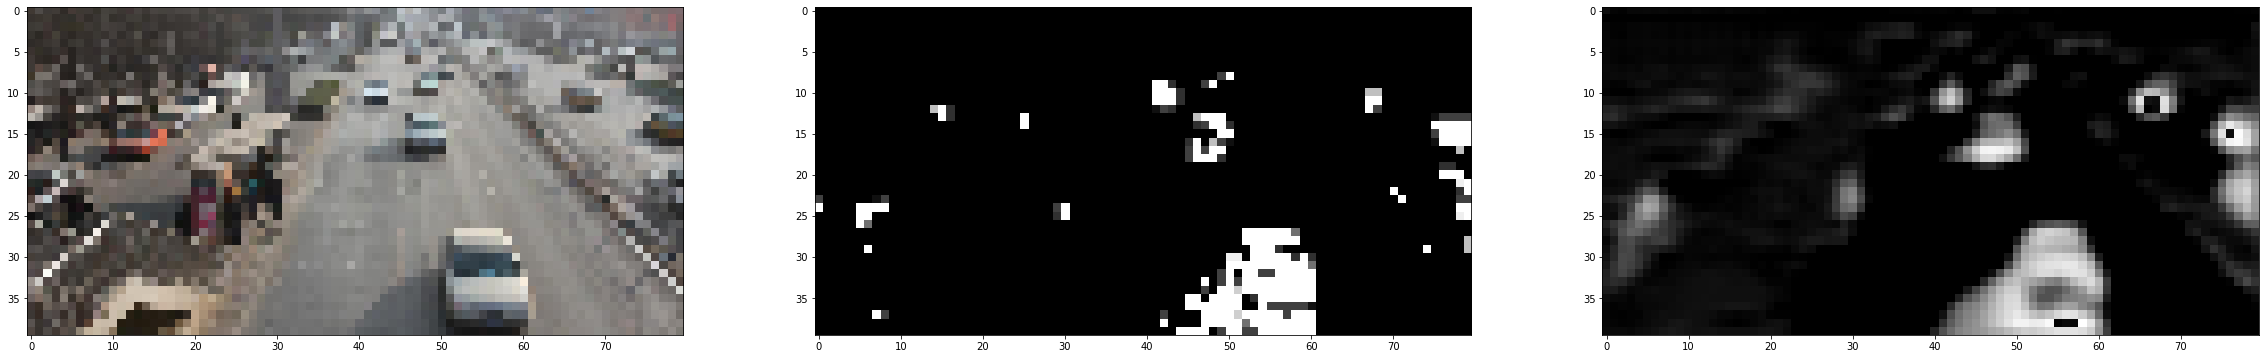

epoch [46/100], loss_total:0.0267, time elapsed:6.4630 (sec)
epoch [47/100], loss_total:0.0269, time elapsed:4.0758 (sec)
epoch [48/100], loss_total:0.0258, time elapsed:4.3750 (sec)
epoch [49/100], loss_total:0.0258, time elapsed:4.2221 (sec)
epoch [50/100], loss_total:0.0255, time elapsed:4.3261 (sec)


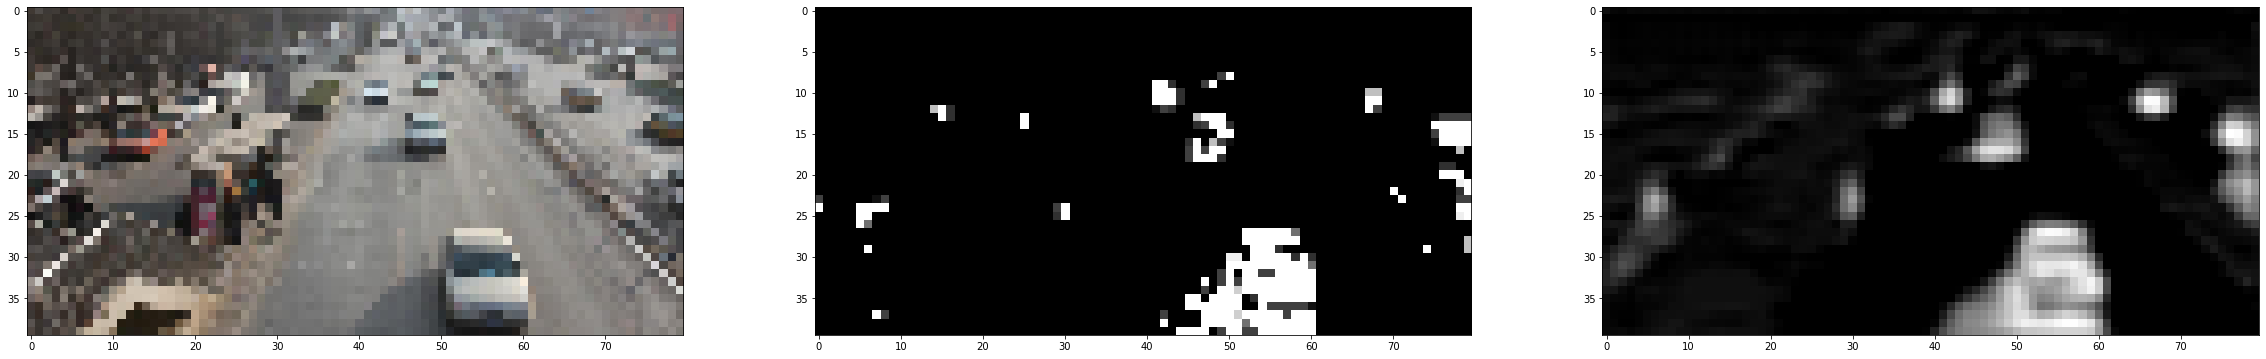

epoch [51/100], loss_total:0.0253, time elapsed:6.4724 (sec)
epoch [52/100], loss_total:0.0255, time elapsed:4.4275 (sec)
epoch [53/100], loss_total:0.0261, time elapsed:4.3484 (sec)
epoch [54/100], loss_total:0.0263, time elapsed:4.3961 (sec)
epoch [55/100], loss_total:0.0254, time elapsed:4.2825 (sec)


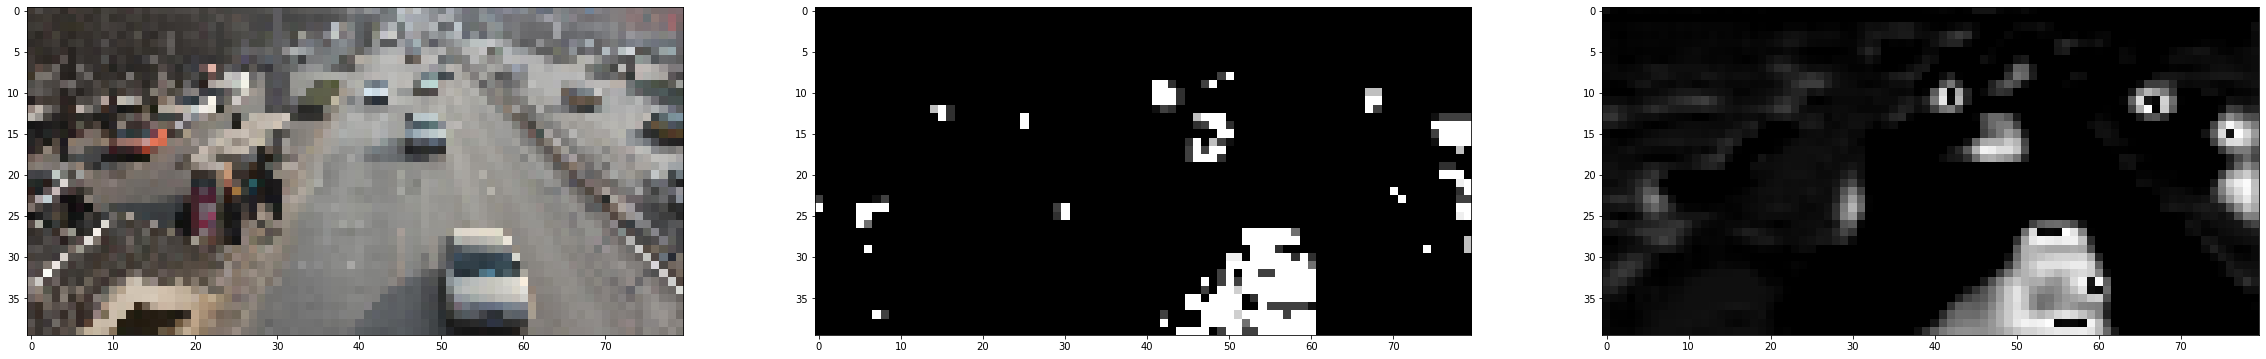

epoch [56/100], loss_total:0.0256, time elapsed:6.6067 (sec)
epoch [57/100], loss_total:0.0251, time elapsed:4.1116 (sec)
epoch [58/100], loss_total:0.0240, time elapsed:4.3390 (sec)
epoch [59/100], loss_total:0.0244, time elapsed:4.2162 (sec)
epoch [60/100], loss_total:0.0237, time elapsed:4.2000 (sec)


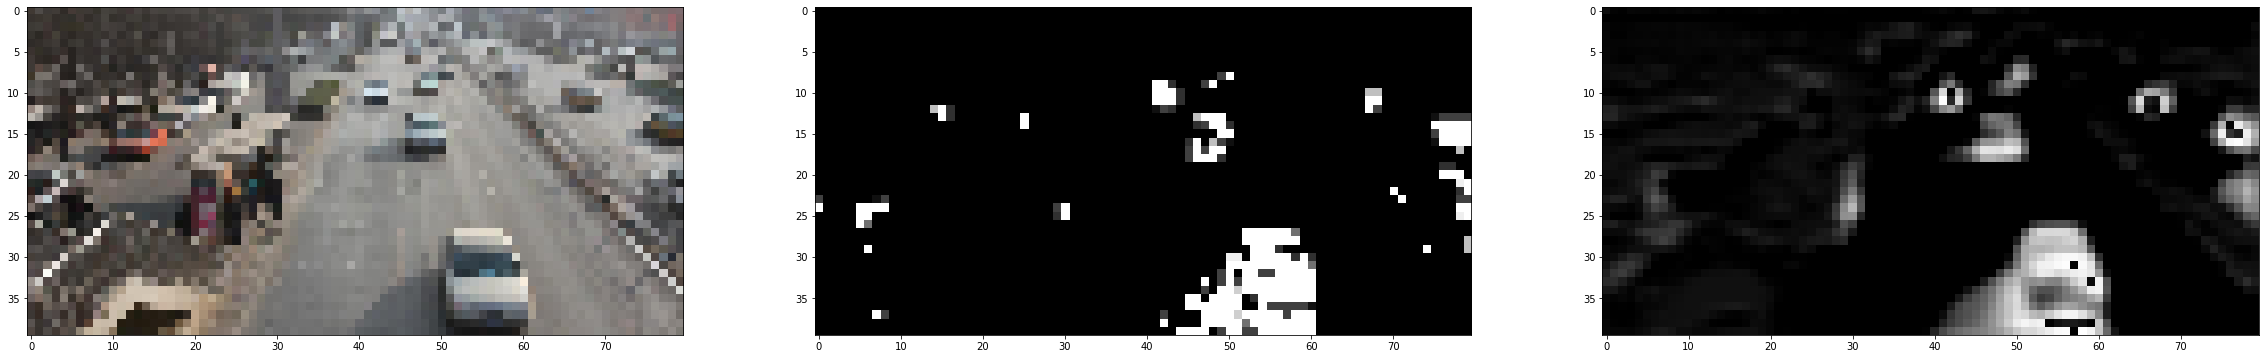

epoch [61/100], loss_total:0.0238, time elapsed:6.8210 (sec)
epoch [62/100], loss_total:0.0237, time elapsed:4.4322 (sec)
epoch [63/100], loss_total:0.0238, time elapsed:4.4567 (sec)
epoch [64/100], loss_total:0.0235, time elapsed:4.5939 (sec)
epoch [65/100], loss_total:0.0232, time elapsed:4.5027 (sec)


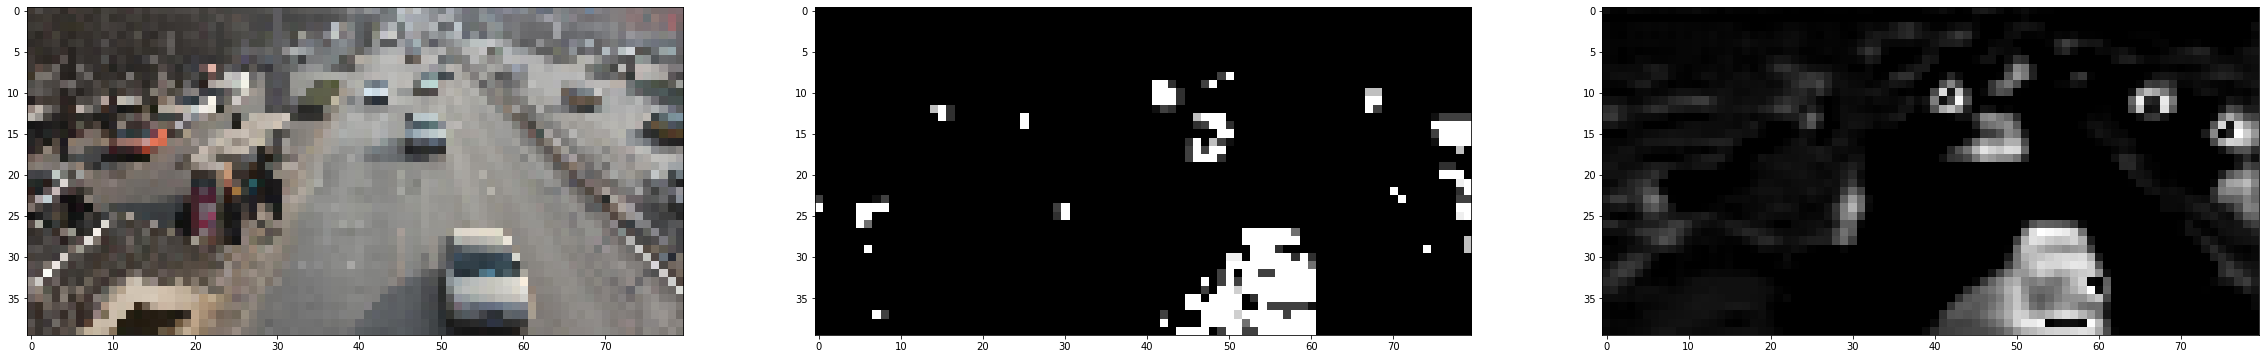

epoch [66/100], loss_total:0.0240, time elapsed:6.5889 (sec)
epoch [67/100], loss_total:0.0227, time elapsed:4.3860 (sec)
epoch [68/100], loss_total:0.0228, time elapsed:4.4197 (sec)
epoch [69/100], loss_total:0.0228, time elapsed:4.3059 (sec)
epoch [70/100], loss_total:0.0227, time elapsed:4.4565 (sec)


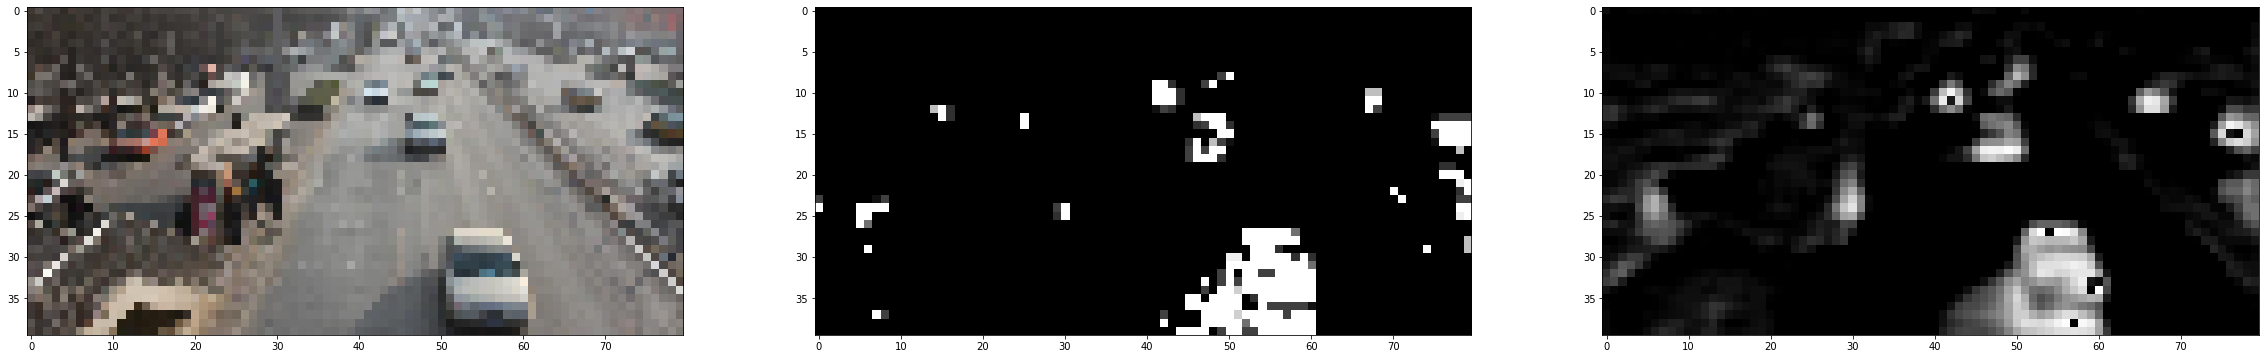

epoch [71/100], loss_total:0.0225, time elapsed:6.5405 (sec)
epoch [72/100], loss_total:0.0223, time elapsed:4.4433 (sec)
epoch [73/100], loss_total:0.0224, time elapsed:4.4331 (sec)
epoch [74/100], loss_total:0.0222, time elapsed:4.3552 (sec)
epoch [75/100], loss_total:0.0222, time elapsed:4.3303 (sec)


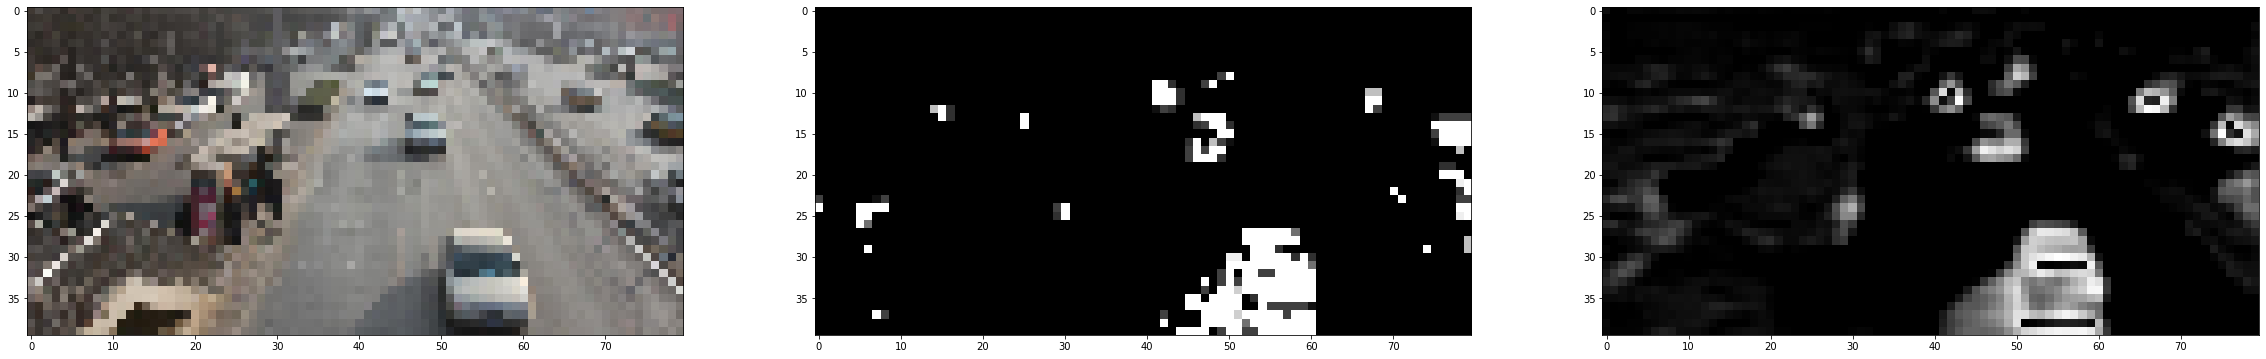

epoch [76/100], loss_total:0.0218, time elapsed:6.6566 (sec)
epoch [77/100], loss_total:0.0218, time elapsed:4.3829 (sec)
epoch [78/100], loss_total:0.0222, time elapsed:4.1679 (sec)
epoch [79/100], loss_total:0.0217, time elapsed:4.1820 (sec)
epoch [80/100], loss_total:0.0215, time elapsed:4.3260 (sec)


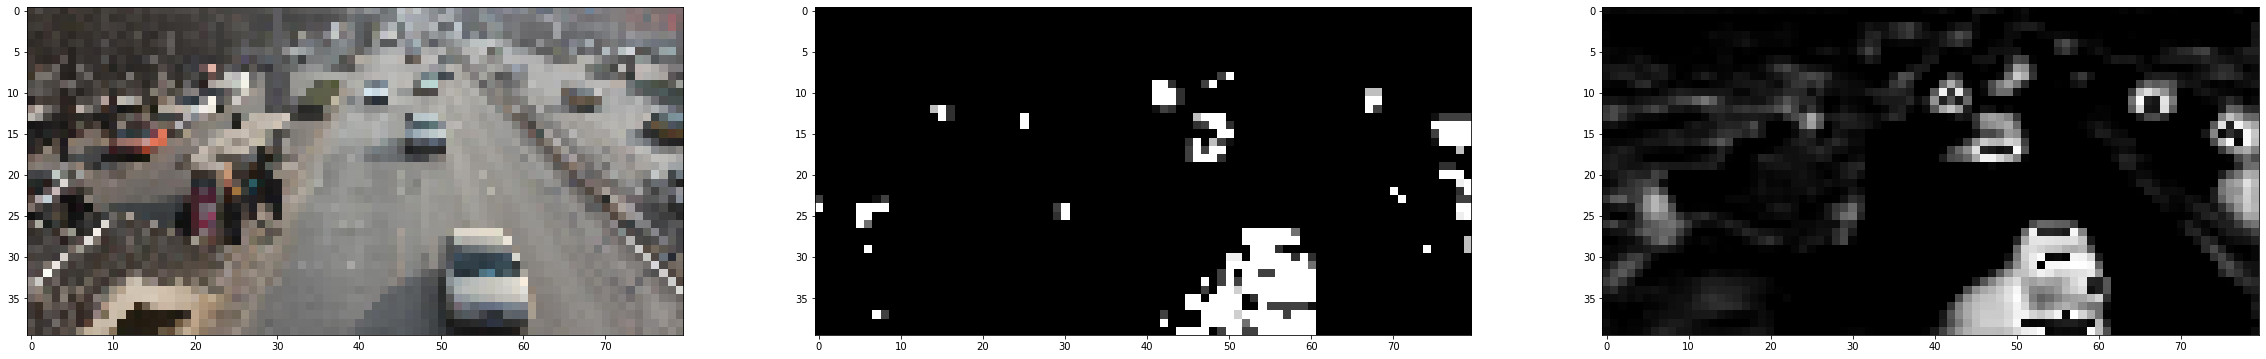

epoch [81/100], loss_total:0.0221, time elapsed:6.7462 (sec)
epoch [82/100], loss_total:0.0232, time elapsed:4.3115 (sec)
epoch [83/100], loss_total:0.0214, time elapsed:4.3355 (sec)
epoch [84/100], loss_total:0.0219, time elapsed:4.3096 (sec)
epoch [85/100], loss_total:0.0217, time elapsed:4.1281 (sec)


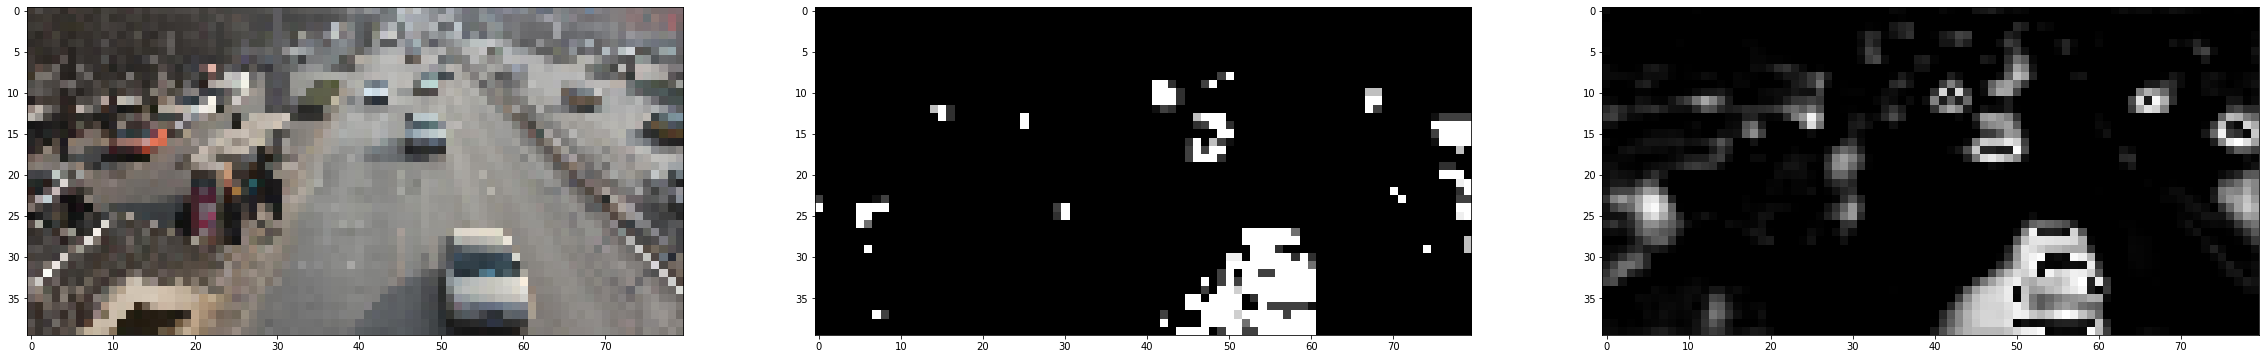

epoch [86/100], loss_total:0.0216, time elapsed:6.3938 (sec)
epoch [87/100], loss_total:0.0211, time elapsed:4.1755 (sec)
epoch [88/100], loss_total:0.0220, time elapsed:4.1923 (sec)
epoch [89/100], loss_total:0.0217, time elapsed:4.2256 (sec)
epoch [90/100], loss_total:0.0212, time elapsed:4.1730 (sec)


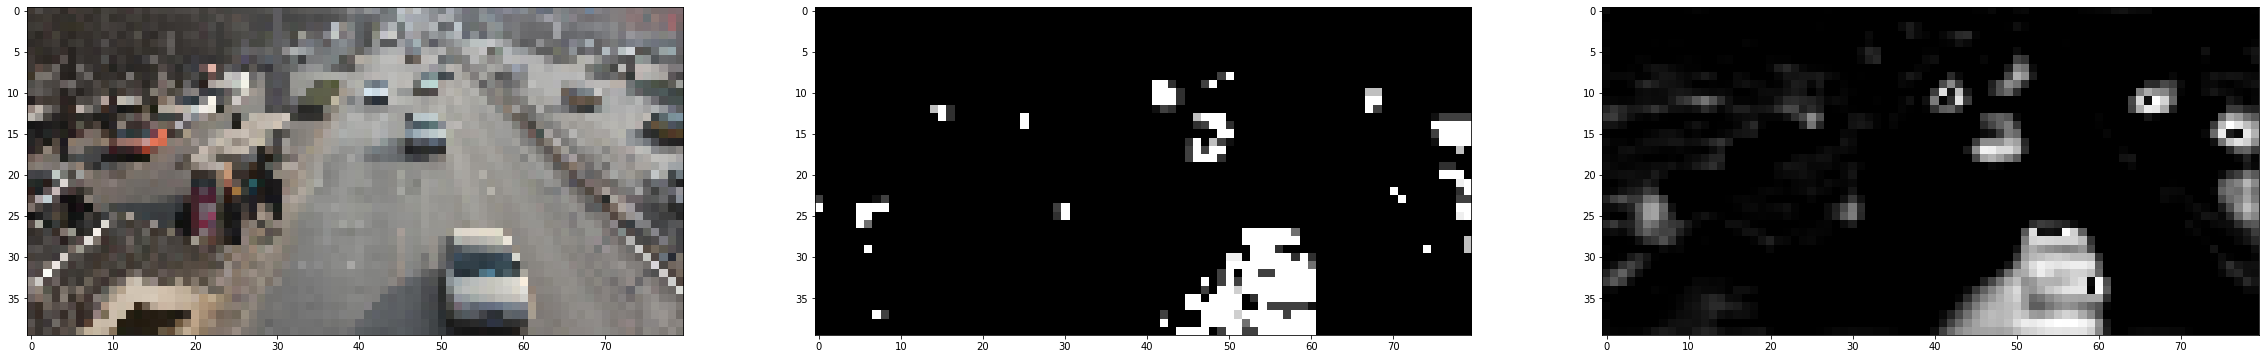

epoch [91/100], loss_total:0.0210, time elapsed:6.5204 (sec)
epoch [92/100], loss_total:0.0210, time elapsed:4.1083 (sec)
epoch [93/100], loss_total:0.0210, time elapsed:4.1415 (sec)
epoch [94/100], loss_total:0.0212, time elapsed:4.1591 (sec)
epoch [95/100], loss_total:0.0208, time elapsed:4.3293 (sec)


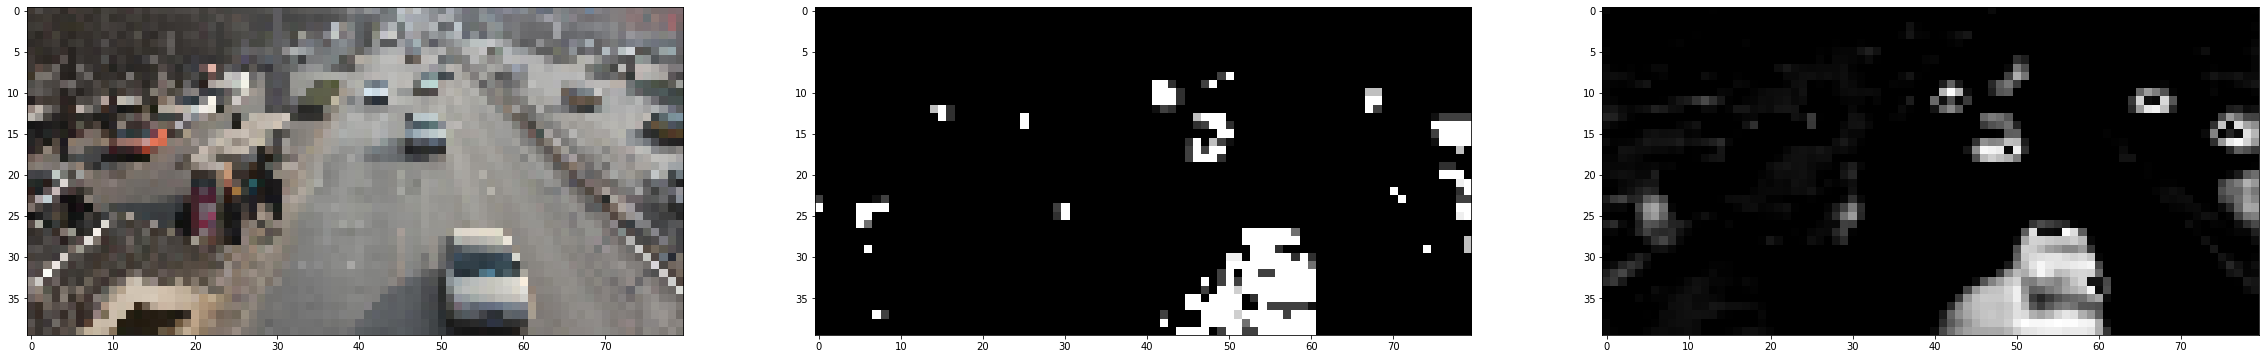

epoch [96/100], loss_total:0.0203, time elapsed:6.4356 (sec)
epoch [97/100], loss_total:0.0200, time elapsed:4.1802 (sec)
epoch [98/100], loss_total:0.0203, time elapsed:4.4280 (sec)
epoch [99/100], loss_total:0.0206, time elapsed:4.4866 (sec)
epoch [100/100], loss_total:0.0201, time elapsed:4.1342 (sec)


In [132]:
## Paper training stats
# learning_rate = 0.003
# dropout rate is 0.65
# batch size is 10
# learning rate dropped by 10 every 1000 iteration
# training stopped at 50000 iterations (assuming this is epoch)
learning_rate = 0.0001 # our loop starts by dividing 10
total_epochs = 100
l2_reg = 1e-6

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = l2_reg)
loss_amp_factor = 1
#optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
for epoch in range(total_epochs):
 #   if epoch % 1000 == 0:
 #       optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)
    
    st = time.perf_counter()
    for i, images in enumerate(train_loader):    # Ignore image labels
        #generate hsv images
        #hsv_images = torch.from_numpy(cv2.cvtColor(images, cv2.COLOR_RGB2HSV))
        #hsv_images_cuda = hsv_images.cuda()
        images_cuda = images.cuda()
        images_input_cuda = images_cuda[:,:3,:,:]
        images_output_cuda = images_cuda[:,3:,:,:]
        
        
        compressed, final = model(images_input_cuda)  
        #print_grad("Before zero_grad") ##
        #if softmax, we need to process the final layer -> perform argmax operations 
        #channels is 1
        
        
        
        
        optimizer.zero_grad()
        #final = background + foreground
        #final[final > 1] = 1
        #final[final < 0] = 0
        loss_all = distance(final, images_output_cuda)
        loss_all.backward()
        #print_grad("After 2nd loss backward")
        optimizer.step()
        #print_grad("After 2nd grad application")
        
        # while training, I want to investigate how my images change...so let's write code for that
        if epoch % 5 == 0 and i == 1:
            original_cpu = convert_one(images_output_cuda)
            final_cpu = convert_one(final)
            images_cpu = convert(images_input_cuda)
            
            
            fig = plt.figure(figsize=(40,80))
            columns = 3
            rows = 1
            for j in range(columns):
                fig.add_subplot(rows,columns,j + 1)
                if j == 0:
                    plt.imshow(images_cpu[0])
                if j == 1:
                    plt.imshow(original_cpu[0], cmap = 'gray')
                if j == 2:
                    plt.imshow(final_cpu[0], cmap = 'gray')
           
            plt.show()

    print('epoch [{}/{}], loss_total:{:.4f}, time elapsed:{:.4f} (sec)'.format(epoch+1, total_epochs, loss_all.data, time.perf_counter() - st))
    

In [ ]:
"""
def imshow_no_ax(img, normalize=True):
    Tiny helper to show images as uint8 and remove axis labels
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_no_ax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_no_ax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_no_ax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_no_ax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_no_ax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_no_ax(out[1, 1])
plt.show()


columns = 3
    rows = 1
    for i in range(n_samples):
        if i % 20 == 0:
            plt.figure(figsize=(40,80))
            for j in range(columns):
                print("image number =>",i)
                ax = plt.subplot(rows,columns,j + 1)
                if j == 0:     
                    ax.imshow(image_cpu[i])
                if j == 1:
                    ax.imshow(final_cpu[i], cmap = 'gray')
                if j == 2:
                    ax.imshow(original_cpu[i], cmap = 'gray')

            plt.show()

"""

In [133]:
# Post processing Step - Thresholding / blurring / extending....
# Let's test -> save these segmented images for generating indexes (we need to perform tests on these too)

batch_size = 64
n_samples, H, W, C = X_test_norm.shape

test_data = torch.from_numpy(X_test_norm).float()
test_data = test_data.permute(0,3,1,2)
seg_data = torch.from_numpy(seg_test_norm).float()
seg_data = seg_data.unsqueeze_(-1)
print(seg_data.size())
seg_data = seg_data.permute(0,3,1,2)
print(seg_data.size())


test_loader = torch.utils.data.DataLoader(torch.cat((test_data,seg_data), dim = 1), shuffle=False, batch_size=batch_size, num_workers=4, drop_last=True)

#collect the generated segmented image
seg_gen_data = np.ndarray(shape=(n_samples, H, W))

for i, images in enumerate(test_loader):    # Ignore image labels
    images_cuda = images.cuda()
    images_input_cuda = images_cuda[:,:3,:,:]
    images_output_cuda = images_cuda[:,3:,:,:]


    compressed, final = model(images_input_cuda)  
    #print_grad("Before zero_grad") ##

    # while training, I want to investigate how my images change...so let's write code for that
    image_cpu = convert(images_input_cuda)
    original_cpu = convert_one(images_output_cuda)
    final_cpu = convert_one(final)
    n_samples = image_cpu.shape[0]
    assert(image_cpu.shape[0] == original_cpu.shape[0])
    assert(image_cpu.shape[0] == final_cpu.shape[0])
    
    seg_gen_data[i*batch_size:(i+1)*batch_size] = final_cpu

output_seg = seg_gen_data.astype(np.uint8)
input_test_images = X_test_norm * 255.0
input_test_images = input_test_images.astype(np.uint8)


torch.Size([2085, 40, 80, 1])
torch.Size([2085, 1, 40, 80])


/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


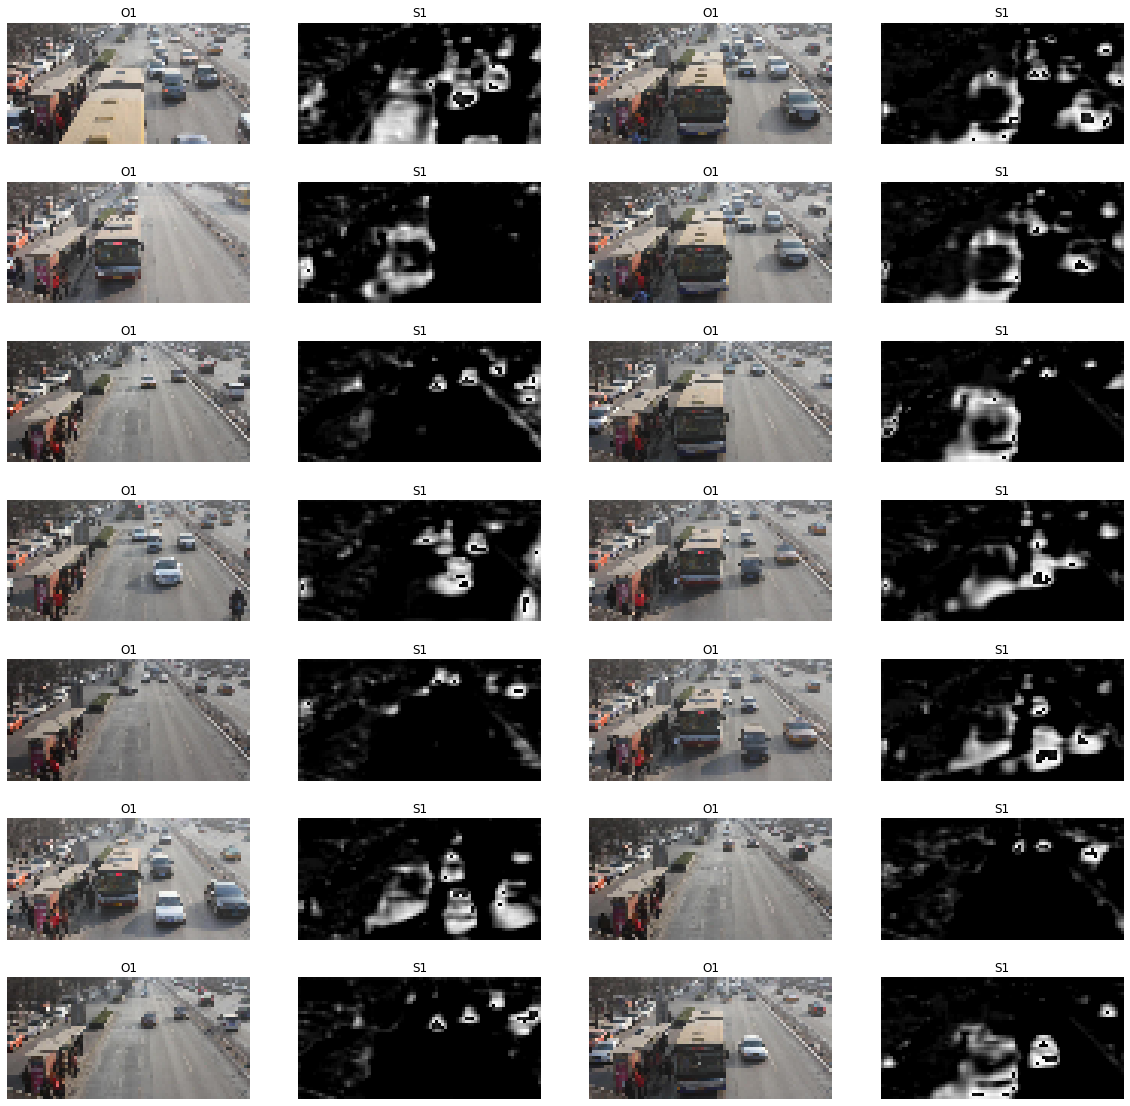

In [134]:
## Now we have to display the images
# Make sure the segmentations are correct

def display_output_random(input_test_images, output_seg):
    assert(output_seg.shape[0] == input_test_images.shape[0])

    def display_img(img, gray = False):
        if gray:
            plt.imshow(img, cmap = 'gray')
        else:
            plt.imshow(img)
        plt.gca().axis('off')

    n_samples = output_seg.shape[0]
    import random
    rows = 7
    cols = 4
    plt.figure(figsize=(20,20))

    for i in range(0, rows * cols, 2):
        plt.subplot(rows, cols, i+1)
        random_index = random.randint(0, n_samples)
        display_img(input_test_images[random_index])
        plt.title('O1')
        plt.subplot(rows,cols, i+2)
        display_img(output_seg[random_index], gray = True)
        plt.title('S1')

        if i+4 < rows * cols:
            plt.subplot(rows, cols, i+3)
            random_index = random.randint(0, n_samples)
            display_img(input_test_images[random_index])
            plt.title('O2')
            plt.subplot(rows, cols, i+4)
            display_img(output_seg[random_index], gray = True)
            plt.title('S2')
display_output_random(input_test_images, output_seg)


In [ ]:


"""


# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
print("sure foreground")
plt.imshow(sure_fg, cmap = 'gray')
plt.show()    
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

print("final")
plt.imshow(unknown, cmap = 'gray')
plt.show()

"""

In [138]:
def post_process(seg_matrix):
    ## Assume seg_matrix is of shape (n_samples, height, width)
    seg_matrix = seg_matrix.astype(np.uint8)
    seg_post = np.copy(seg_matrix)
    n_samples, height, width = seg_matrix.shape
    threshold = 100
    height_tmp = 100
    width_tmp = 200
    # We need to reshape the image 2 times because of dilation and erosion processes
    
    for i in range(n_samples):
        curr = np.copy(seg_matrix[i])
        curr = cv2.resize(curr, (width_tmp, height_tmp))
        #1. threshold the image
        ret, thresh = cv2.threshold(curr,0,255,cv2.THRESH_OTSU)
        #2. erode the image
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN, kernel, iterations = 3)
        #3. dilate the image
        sure_bg = cv2.dilate(opening,kernel,iterations=5)
        #4. resize back the postprocessed image
        seg_post[i] = cv2.resize(sure_bg, (width, height))
        
    return seg_post
    
    

In [139]:
post_seg = post_process(output_seg)

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


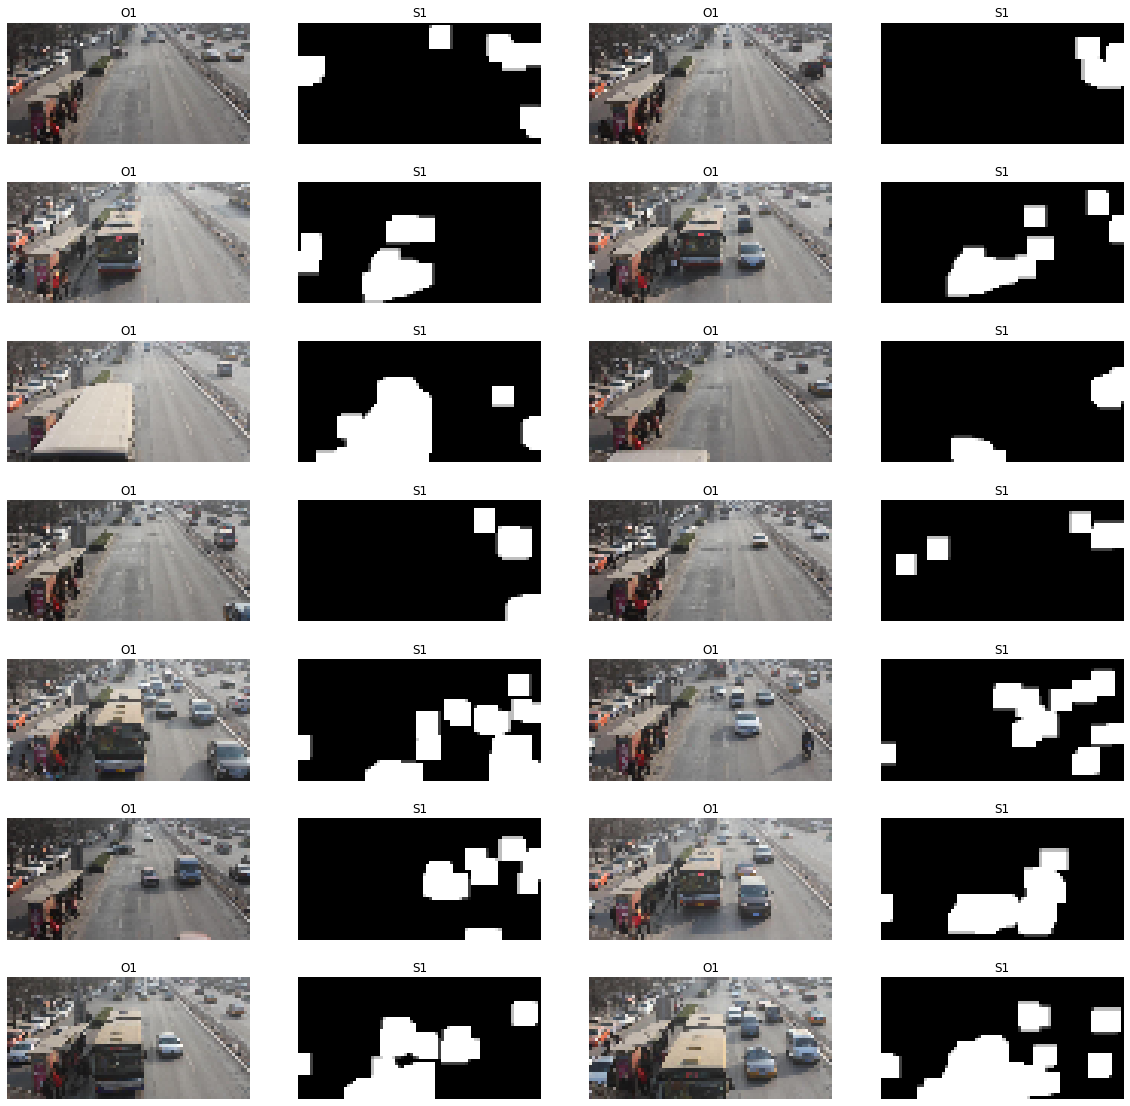

In [140]:
display_output_random(input_test_images, post_seg)

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


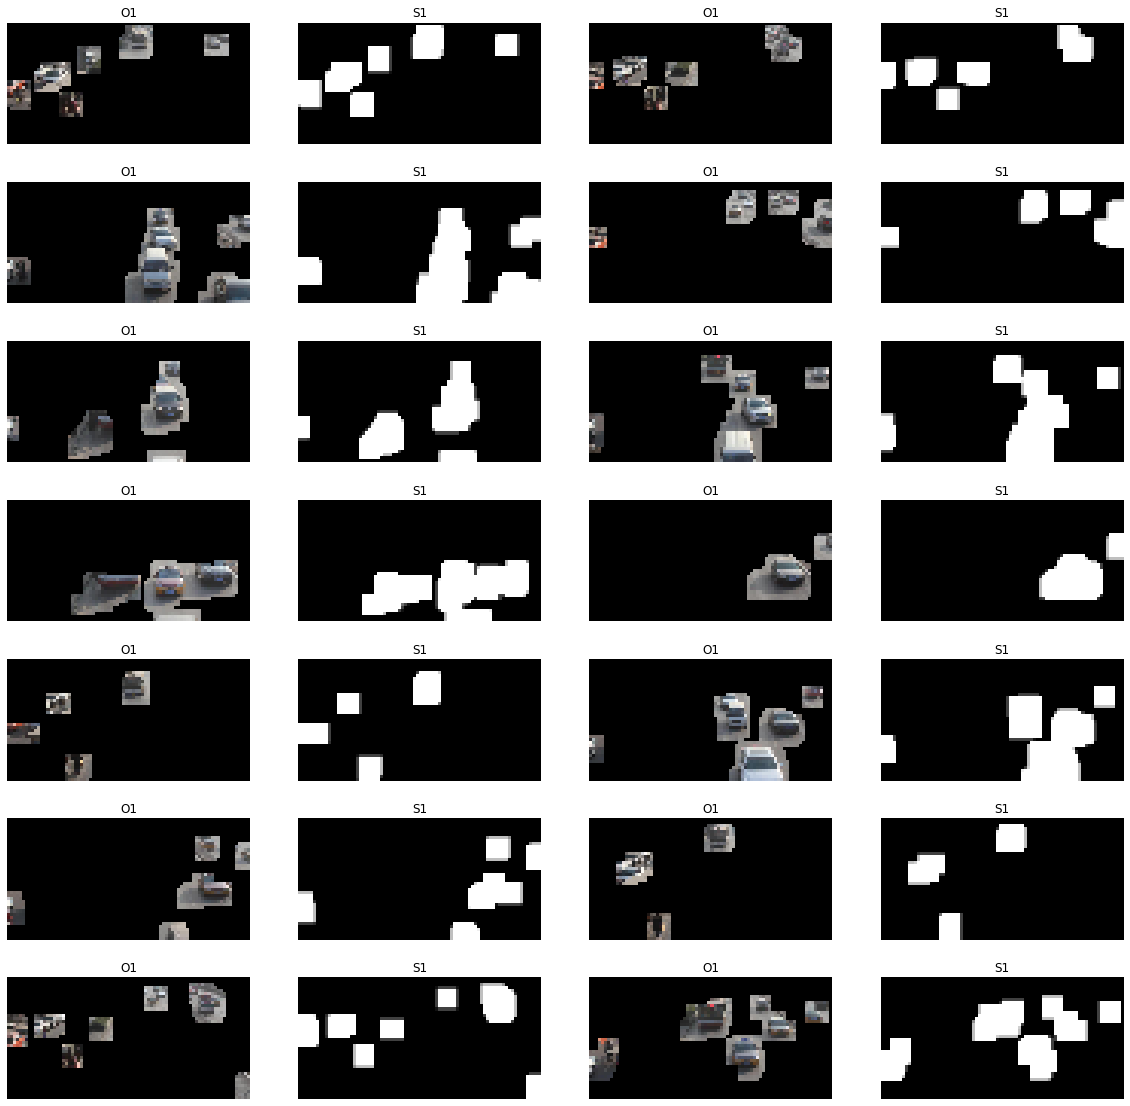

In [142]:
# TODO: Need to overlap these segmented images with the original image to make sure they overlap
# Maybe there is binary operation for masking? Black is 0, white is 255
# cv2.bitwise_and(img, img, mask = mask)??
def overlap(input_test_images, post_seg):
    # we will generate overlapped images for entire matrix
    assert(input_test_images.shape[0] == post_seg.shape[0])
    overlapped = np.ndarray(shape = input_test_images.shape)
    n_sample = input_test_images.shape[0]
    for i in range(n_sample):
        overlapped[i] = cv2.bitwise_or(input_test_images[i], input_test_images[i], mask = post_seg[i])
    overlapped = overlapped.astype(np.uint8)
    return overlapped

overlapped_images = overlap(input_test_images, post_seg)
display_output_random(overlapped_images, post_seg)

In [43]:
# SAVING / LOADING FUNCTIONS

torch.save(model.state_dict(), 'saved_model_state.pt')
#loading model.load_state_dict(torch.load('saved_model_state.pt'))
# Loading the model
model = Autoencoder_seg().cuda()
model.load_state_dict(torch.load('saved_model_state.pt'))
#####################################################
# Save the model results..
np.save('model_test_output.npy', output_seg)
#####################################################
#output_seg = np.load('model_test_output.npy')
output_seg = np.load('model_test_output.npy')
#####################################################
#np.save('input_test_images.npy', input_test_images)
input_test_images = np.load('input_test_images.npy')
#####################################################
display_output_random(input_test_images, output_seg)

In [41]:
# Detect contours
# Create patches and let's save this work in an .npy so that we can load them whenever we want
# Actually, let's make an another file to work out the cbir magic

def draw_contours(original_img, img):
    import random as rng
    rng.seed(12345)
    import cv2 as cv
    contours, aaaa = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No contours in image")
        return
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        boundRect[i] = cv.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])

    drawing = np.copy(original_img)
    
    
    for i in range(len(contours)):
        color = (random.randint(0, 255),random.randint(0, 255),random.randint(0, 255))
        #cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        #cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    plt.imshow(drawing)
    plt.title('Contour Image'), plt.xticks([]), plt.yticks([])
    plt.show()
    return

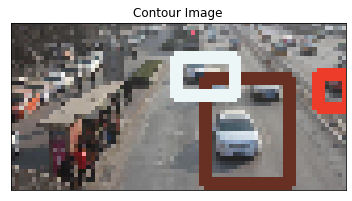

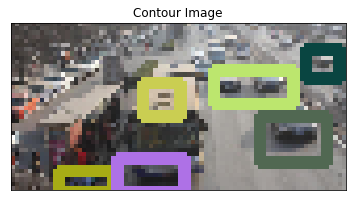

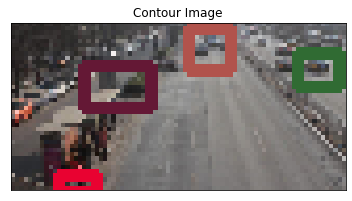

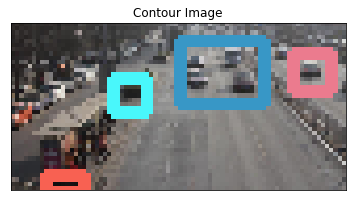

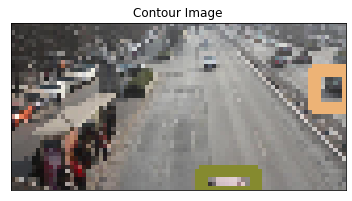

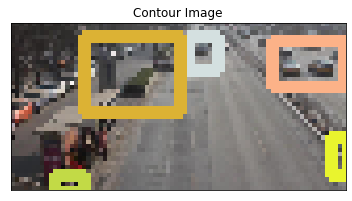

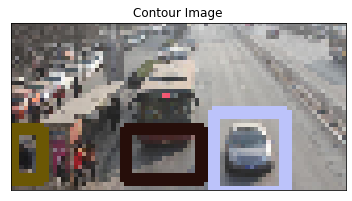

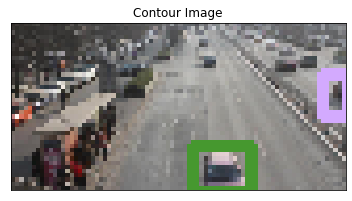

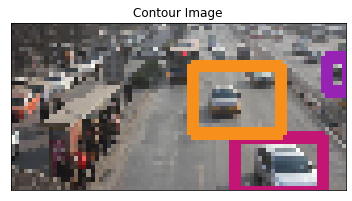

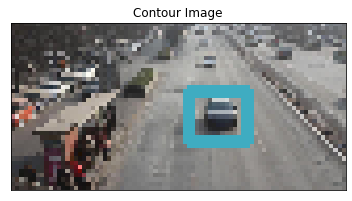

In [44]:
#input_test_images
#post_seg
rows = 5
cols = 2
n_samples = input_test_images.shape[0]
for i in range(10):
    random_index = random.randint(0, n_samples)
    draw_contours(input_test_images[random_index], post_seg[random_index])
    

In [45]:
output_seg.shape

(2085, 40, 80)

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


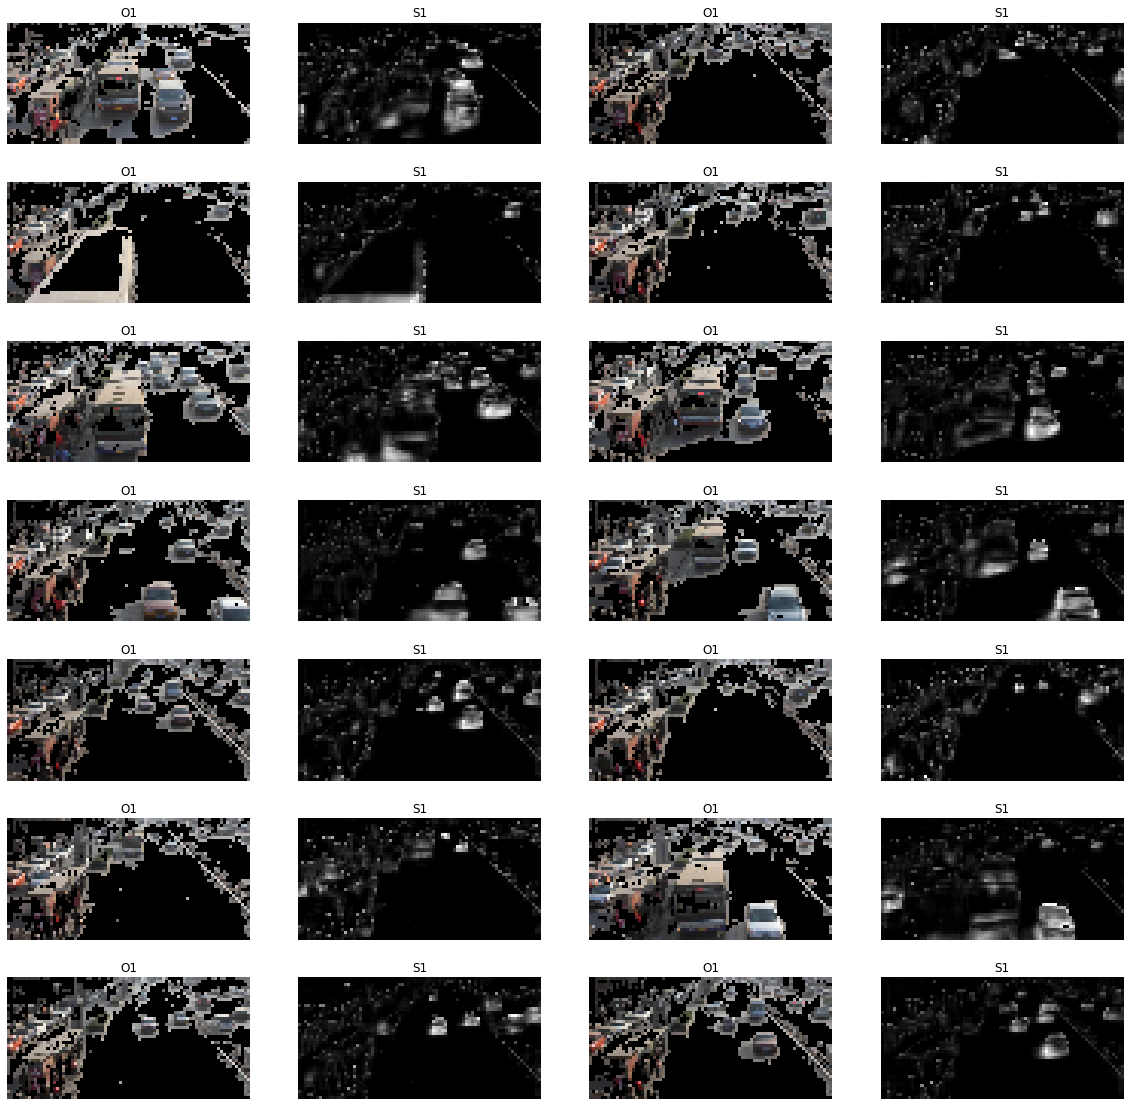

In [47]:
#overlapped_images_tmp = overlap(input_test_images, output_seg)
display_output_random(overlapped_images_tmp, output_seg)

/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/nethome/jbang36/anaconda3/envs/eva_37/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


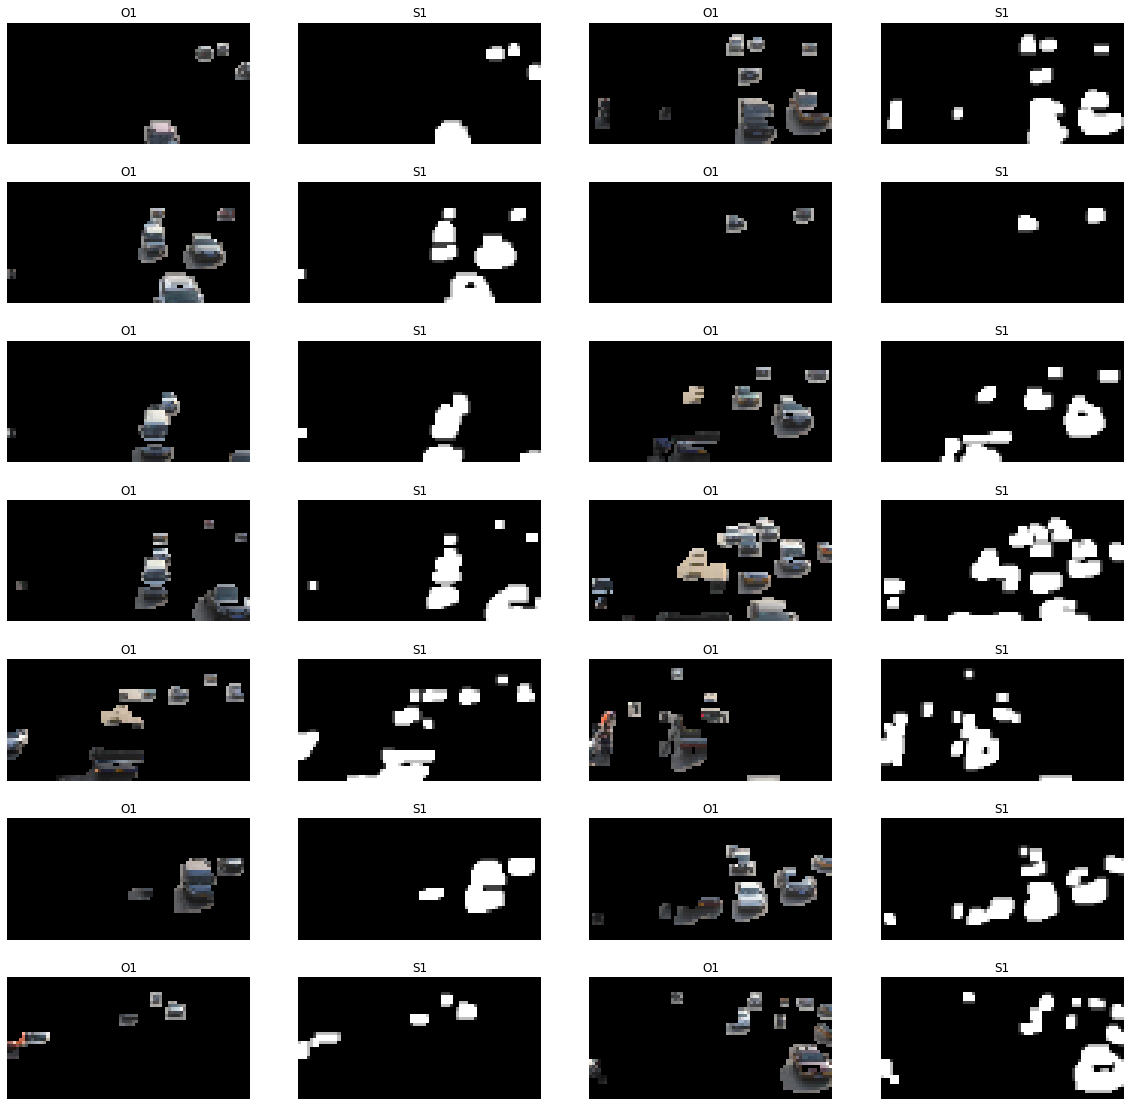

In [63]:
def post1(original_img_matrix, seg_output):
    assert(original_img_matrix.shape[0] == seg_output.shape[0])
    new_seg = np.ndarray(shape = seg_output.shape)
    width_tmp = 200
    height_tmp = 100
    height = seg_output.shape[1]
    width = seg_output.shape[2]
    kernel = np.ones((3,3),np.uint8)
    
    for i in range(original_img_matrix.shape[0]):
        tmp = np.copy(seg_output[i])
        tmp = cv2.resize(tmp, (width_tmp, height_tmp))
        
        #1. Erosion
        opening = cv2.morphologyEx(tmp,cv2.MORPH_OPEN, kernel, iterations = 2)
        #2. Dilation
        sure_bg = cv2.dilate(opening,kernel,iterations=1)
        #3. Threshold
        ret, thresh = cv2.threshold(sure_bg, 0, 255, cv2.THRESH_OTSU)
        new_seg[i] = cv2.resize(thresh, (width, height))
        
    new_seg = new_seg.astype(np.uint8)
    return new_seg


seg_test1 = post1(input_test_images, output_seg)
overlapped_images_tmp = overlap(input_test_images, seg_test1)
display_output_random(overlapped_images_tmp, seg_test1)



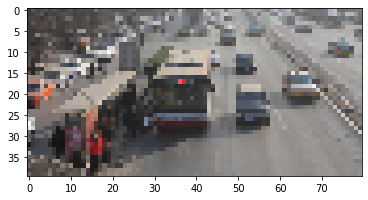

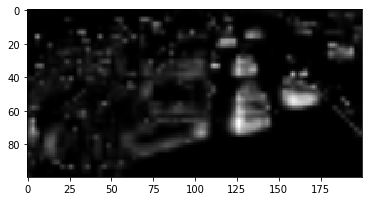

thresholded


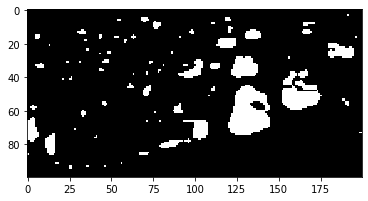

eroded


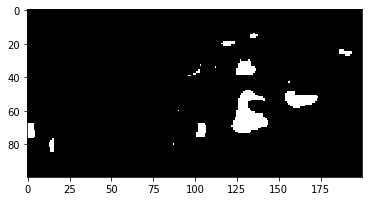

gradient


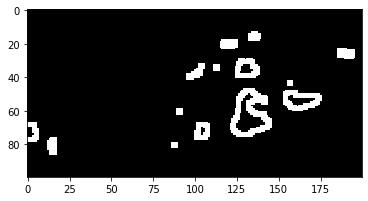

In [80]:
random_int = random.randint(0, output_seg.shape[0])
play = np.copy(output_seg[random_int])
play = cv2.resize(play, (200, 100))

plt.imshow(input_test_images[random_int])
plt.show()

plt.imshow(play, cmap = 'gray')
plt.show()

ret, thresh = cv2.threshold(play, 0, 255, cv2.THRESH_OTSU)
print("thresholded")
plt.imshow(thresh, cmap = 'gray')
plt.show()

print('eroded')
kernel = np.ones((4,4),np.uint8)
erosion = cv2.erode(thresh,kernel,iterations = 1)
plt.imshow(erosion, cmap = 'gray')
plt.show()




In [ ]:
def post2(original_img_matrix, seg_output):
    assert(original_img_matrix.shape[0] == seg_output.shape[0])
    new_seg = np.ndarray(shape = seg_output.shape)
    width_tmp = 200
    height_tmp = 100
    height = seg_output.shape[1]
    width = seg_output.shape[2]
    kernel = np.ones((3,3),np.uint8)
    
    for i in range(original_img_matrix.shape[0]):
        tmp = np.copy(seg_output[i])
        tmp = cv2.resize(tmp, (width_tmp, height_tmp))
        
        #1. Erosion
        #opening = cv2.morphologyEx(tmp,cv2.MORPH_OPEN, kernel, iterations = 2)
        #2. Dilation
        #sure_bg = cv2.dilate(opening,kernel,iterations=1)
        #3. Threshold
        #ret, thresh = cv2.threshold(sure_bg, 0, 255, cv2.THRESH_OTSU)
        #new_seg[i] = cv2.resize(thresh, (width, height))
        
        
    new_seg = new_seg.astype(np.uint8)
    return new_seg


seg_test1 = post1(input_test_images, output_seg)
overlapped_images_tmp = overlap(input_test_images, seg_test1)
display_output_random(overlapped_images_tmp, seg_test1)